In [1]:
import numpy as np
import pandas as pd
import datetime
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap
import geopandas as gpd
import shapely
from tabula import read_pdf
import re

%matplotlib inline

plt.style.use('fivethirtyeight')
%config InlineBackend.figure_format = 'retina'

This notebook is meant to be a venue for looking at the housing datasets for my General Assembly capstone project.

In this project I hope to analyze and target the housing (rental?) prices for San Francisco (and maybe another city). Instead of simply using housing prices, whether asking/sale prices or posted rental rates, I will try to incorporate the wealth of other information from neighborhoods to factor in a more intelligent pricing scheme. In other words, given a price you can afford, where can you get the best deal. This will try to take into account the specific desires of the buyer/renter specific to regions; i.e. is there a higher preference for living near good food, parks, bars, public transit stops, et cetera?

Below we look through some of the datasets publicly availabe to see what features we use in this project. In most cases it is advantageous to have data points connected to geography - latitude/longitude coordinates included in datasets.

## Airbnb data

These data were downloaded from a third party website that supplies Airbnb sata from cities around the world. An elaborate list of disclaimers is available here (http://insideairbnb.com/about.html#disclaimers). It seems like they took a reasonable approach at cleaning the data, but this should be referenced to be aware of biases.

In [2]:
bnb_cal = pd.read_csv('../ga_project_data/airbnb_data/calendar.csv')
bnb_listings_sum = pd.read_csv('../ga_project_data/airbnb_data/listings_sum.csv')
bnb_listings = pd.read_csv('../ga_project_data/airbnb_data/listings.csv')
bnb_reviews_sum = pd.read_csv('../ga_project_data/airbnb_data/reviews_sum.csv')
bnb_reviews = pd.read_csv('../ga_project_data/airbnb_data/reviews.csv')

/Users/taylorkilian/anaconda3/envs/dsi/lib/python2.7/site-packages/IPython/core/interactiveshell.py:2717: DtypeWarning: Columns (43) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [3]:
print bnb_cal.shape
bnb_cal.head()

(3145935, 4)


listing_id        date available price
0    11187767  2017-03-12         f   NaN
1    11187767  2017-03-11         f   NaN
2    11187767  2017-03-10         f   NaN
3    11187767  2017-03-09         f   NaN
4    11187767  2017-03-08         f   NaN

There are two types of availability, 't' and 'f', not sure what they stand for, but only 't's have prices, making beleive that 't' means true and 'f' means false - probably a safe bet that that is the case. 't' or true must mean that the apartment is unavailable, perhaps it doesn't matter given that the price probably doesn't change much over the course of a month. If there are pricing changes for listings then we can track them month by month or year by year.

In [4]:
bnb_listings.thumbnail_url.values[0]

'https://a2.muscache.com/im/pictures/e8652800-ae74-4322-824e-a9c7e5deda63.jpg?aki_policy=small'

In [5]:
print bnb_listings.shape
bnb_listings.head().T

(8619, 95)


0  \
id                                                                         11187767   
listing_url                                   https://www.airbnb.com/rooms/11187767   
scrape_id                                                            20160702162156   
last_scraped                                                             2016-07-02   
name                                             Huge Seacliff Penthouse With Views   
summary                           Amazing views from this immense 3 bedroom/ 2 b...   
space                             Spacious patio deck, library with over 300 mov...   
description                       Amazing views from this immense 3 bedroom/ 2 b...   
experiences_offered                                                            none   
neighborhood_overview             The neighborhood includes Legion of Honor, Sut...   
notes                             We require a separate rental agreement to be s...   
transit                           Public Transportation including Muni and the B...   
access                            Guests have access to the entire flat includin...   
interaction                         I am available 24 hours a day during your stay.   
house_rules                       1. Smoking is NOT allowed in the Property, Com...   
thumbnail_url                     https://a2.muscache.com/im/pictures/e8652800-a...   
medium_url                        https://a2.muscache.com/im/pictures/e8652800-a...   
picture_url                       https://a2.muscache.com/im/pictures/e8652800-a...   
xl_picture_url                    https://a2.muscache.com/im/pictures/e8652800-a...   
host_id                                                                    58242037   
host_url                                 https://www.airbnb.com/users/show/58242037   
host_name                                                                  Jonathan   
host_since                                                               2016-02-10   
host_location                              San Francisco, California, United States   
host_about                        Property Manager for Watt Property Management,...   
host_response_time                                                   within an hour   
host_response_rate                                                             100%   
host_acceptance_rate                                                           100%   
host_is_superhost                                                                 f   
host_thumbnail_url                https://a2.muscache.com/im/pictures/351d2fbc-4...   
...                                                                             ...   
guests_included                                                                   1   
extra_people                                                                  $0.00   
minimum_nights                                                                    2   
maximum_nights                                                                   28   
calendar_updated                                                              today   
has_availability                                                                NaN   
availability_30                                                                   8   
availability_60                                                                  31   
availability_90                                                                  61   
availability_365                                                                152   
calendar_last_scraped                                                    2016-07-02   
number_of_reviews                                                                 3   
first_review                                                             2016-03-23   
last_review                                                              2016-06-25   
review_scores_rating                                                            

There are a lot text columns that could be used later for NLP analysis. First the data need to be cleaned so that the useful numeric features can be used in the initial model to predict the prices.

First convert dollar value columns to floats. This is done to the calendar table first, which will not be that useful given that the price information is already given in the main listing table. The calendar table does show that prices for some listings change during certain periods of time, like weekends or holidays. A mean of these prices are taken and then added to the main listing table as a column named 'price_mod'.

In [3]:
bnb_cal.price.value_counts(dropna=False).head(10)

NaN        1909112
$150.00      45065
$200.00      35702
$250.00      33873
$100.00      28943
$300.00      28324
$125.00      27444
$175.00      24212
$120.00      21745
$350.00      20088
Name: price, dtype: int64

In [4]:
def conv_to_float(s):
    if s:
        return float(s)
    else:
        return s
    
def conv_dollars(df, list_of_cols):
    for col in list_of_cols:
        df[col] = df[col].replace(to_replace=r'[^0-9.]+', value='', regex=True)
        df[col] = df[col].apply(conv_to_float)
    return df

In [5]:
bnb_cal['price'] = bnb_cal.price.replace(to_replace=r'[^0-9.]+', value='', regex=True, )
bnb_cal['price'] = bnb_cal.price.apply(conv_to_float, convert_dtype=True)
bnb_cal.price.value_counts(dropna=False).head(10)

NaN       1909112
 150.0      45065
 200.0      35702
 250.0      33873
 100.0      28943
 300.0      28324
 125.0      27444
 175.0      24212
 120.0      21745
 350.0      20088
Name: price, dtype: int64

(0, 2000)

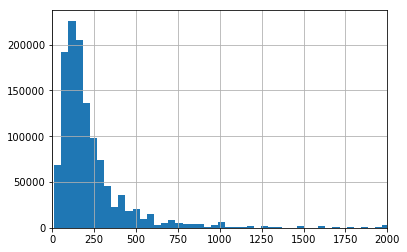

In [6]:
bnb_cal.price.hist(bins=300,)
plt.xlim((0, 2000))

In [7]:
bnb_cal.iloc[17500]

listing_id      13590516
date          2016-07-21
available              t
price                735
Name: 17500, dtype: object

The Airbnb calendar dataset gives a list of prices for the listings over the past year. If the unit is available for rent, a price is listed. Some listings have the same price over the entire year and other listings have different pricing schemes for certain periods of time. Below, I show a listing that is $90 more expensive on weekends. This may also be the case for some listings over holiday periods or popular vacation times (e.g. spring break or Memorial Day).

In [8]:
print bnb_cal[bnb_cal.listing_id == 13590516].shape
bnb_cal[bnb_cal.listing_id == 13590516].head()

(365, 4)


listing_id        date available  price
17155    13590516  2017-07-01         t  525.0
17156    13590516  2017-06-30         t  525.0
17157    13590516  2017-06-29         t  434.0
17158    13590516  2017-06-28         t  434.0
17159    13590516  2017-06-27         t  434.0

In [9]:
print bnb_listings_sum.shape
bnb_listings_sum.head().T

(8619, 16)


0  \
id                                                        11187767   
name                            Huge Seacliff Penthouse With Views   
host_id                                                   58242037   
host_name                                                 Jonathan   
neighbourhood_group                                            NaN   
neighbourhood                                             Seacliff   
latitude                                                   37.7797   
longitude                                                  -122.51   
room_type                                          Entire home/apt   
price                                                          400   
minimum_nights                                                   2   
number_of_reviews                                                3   
last_review                                             2016-06-25   
reviews_per_month                                             0.88   
calculated_host_listings_count                                   1   
availability_365                                               152   

                                                  1  \
id                                          6938818   
name                            Best Secret in Town   
host_id                                    36381578   
host_name                                    Harris   
neighbourhood_group                             NaN   
neighbourhood                              Seacliff   
latitude                                    37.7807   
longitude                                  -122.506   
room_type                              Private room   
price                                            99   
minimum_nights                                    3   
number_of_reviews                                23   
last_review                              2016-06-16   
reviews_per_month                              1.85   
calculated_host_listings_count                    2   
availability_365                                187   

                                                            2  \
id                                                    9395222   
name                            Ocean Beach, Lands End Escape   
host_id                                              25963295   
host_name                                               Tyler   
neighbourhood_group                                       NaN   
neighbourhood                                        Seacliff   
latitude                                              37.7814   
longitude                                            -122.505   
room_type                                     Entire home/apt   
price                                                     155   
minimum_nights                                              1   
number_of_reviews                                          45   
last_review                                        2016-06-19   
reviews_per_month                                        5.87   
calculated_host_listings_count                              1   
availability_365                                          167   

                                                                  3  \
id                                                          8388658   
name                            Mid-century Seacliff near GG Bridge   
host_id                                                     9996441   
host_name                                                    Howard   
neighbourhood_group                                             NaN   
neighbourhood                                              Seacliff   
latitude                                                    37.7877   
longitude                                                  -122.489   
room_type                                           Entire home/apt   
price                                                           895   
minimum_nights                                     

The reviews table gives some reviews for many of the units listed. Some of listings don't have reviews, either because they are infrequently rented or are too new to have any reviews yet.

In [10]:
bnb_reviews.listing_id.unique().shape

(6396,)

In [11]:
print bnb_reviews.shape
bnb_reviews.head()

(169739, 6)


listing_id        id        date  reviewer_id      reviewer_name  \
0     8308113  47419975  2015-09-18      6288054              Colin   
1     3320213  14805088  2014-06-26     17101713               Faye   
2     3320213  17192435  2014-08-08       182792  Jocelyne & Pontus   
3     3320213  17597907  2014-08-14     19649465          Francesco   
4     3320213  18293826  2014-08-24      1104165             Daniel   

                                            comments  
0  Host was excellent and was contactable / respo...  
1  The place was clean and spacious and the guy t...  
2  This place wasn't as pleasant as we hoped. Had...  
3  Si tratta di una piccola pensione/albergo.\nSt...  
4  Nice room, cool neighbourhood. Note that this ...

In [12]:
print bnb_reviews_sum.shape
bnb_reviews_sum.head()

(169739, 2)


listing_id        date
0     8308113  2015-09-18
1     3320213  2014-06-26
2     3320213  2014-08-08
3     3320213  2014-08-14
4     3320213  2014-08-24

There are far more recent reviews from 2015 and 2016 as airbnb has gotten more popular and more people are listing and renting.

In [13]:
bnb_reviews_sum.date.value_counts()

2015-09-21    569
2016-05-30    491
2016-05-15    489
2015-08-07    487
2016-06-10    486
2016-05-23    465
2016-05-22    464
2015-09-18    461
2016-06-09    459
2016-06-17    453
2016-05-16    452
2016-05-08    445
2016-04-11    445
2016-02-08    442
2016-02-15    438
2015-10-24    438
2016-03-17    432
2016-06-18    429
2016-06-13    420
2016-05-28    414
2015-09-19    412
2016-04-04    406
2015-08-10    405
2016-05-18    404
2016-04-01    402
2016-03-19    401
2016-06-19    397
2016-03-20    396
2016-05-31    392
2016-05-21    391
             ... 
2011-03-23      1
2011-03-24      1
2011-10-15      1
2010-10-30      1
2009-09-14      1
2011-02-27      1
2010-07-31      1
2010-07-30      1
2009-09-11      1
2009-09-12      1
2010-09-03      1
2009-10-03      1
2009-10-05      1
2010-10-16      1
2009-10-08      1
2009-07-15      1
2010-02-13      1
2010-02-17      1
2010-03-30      1
2010-02-15      1
2010-02-14      1
2010-02-18      1
2011-01-12      1
2011-03-02      1
2010-07-07

## SF city data

### 311 records

There are many 311 records or requests in the city records. These could be anything from complaints for sidewalk or light repairs to requests to remove illegal sign postings or paint curbs for parking restrictions.

In [19]:
rec_311 = pd.read_csv('../ga_project_data/sf_city_data/311_case_records/311_records.csv')

In [20]:
print rec_311.shape
rec_311.head()

(1821839, 16)


CaseID                  Opened                  Closed  \
0  322571  11/30/2008 11:53:00 PM  12/01/2008 03:19:00 PM   
1  322568  11/30/2008 11:13:00 PM  07/21/2009 04:24:00 PM   
2  322567  11/30/2008 11:07:00 PM  12/27/2008 06:07:00 AM   
3  322566  11/30/2008 10:56:00 PM  07/21/2009 04:24:00 PM   
4  322565  11/30/2008 10:46:00 PM  12/13/2008 10:50:00 AM   

                  Updated  Status Status Notes  \
0  12/01/2008 03:19:00 PM  Closed          NaN   
1  07/21/2009 04:24:00 PM  Closed          NaN   
2  12/27/2008 06:07:00 AM  Closed          NaN   
3  07/21/2009 04:24:00 PM  Closed          NaN   
4  12/13/2008 10:50:00 AM  Closed          NaN   

                Responsible Agency                      Category  \
0         PUC - Electric/Power - G              General Requests   
1                    DPW Ops Queue              Illegal Postings   
2                    DPW Ops Queue              Illegal Postings   
3                    DPW Ops Queue  Street and Sidewalk Cleaning   
4  RPD Park Service Area GGP Queue         Rec and Park Requests   

                                   Request Type  \
0          puc - electric - request_for_service   
1  Illegal Postings - Posting_Too_Large_in_Size   
2         Illegal Postings - Affixed_Improperly   
3                             Sidewalk_Cleaning   
4                 Park - Structural_Maintenance   

                         Request Details  \
0   puc - electric - request_for_service   
1  Posting_Too_Large_in_Size on Sidewalk   
2         Affixed_Improperly on Sidewalk   
3                                Garbage   
4                                  Other   

                                      Address  Supervisor District  \
0         Intersection of 21ST ST and CAPP ST                    9   
1    Intersection of BUSH ST and VAN NESS AVE                    3   
2  Intersection of EUCLID AVE and MASONIC AVE                    2   
3      1566 HYDE ST, SAN FRANCISCO, CA, 94109                    3   
4     GGP Panhandle, SAN FRANCISCO, CA, 94117                    5   

       Neighborhood                                  Point    Source Media URL  
0           Mission  (37.7571008516766, -122.417811874214)  Voice In       NaN  
1          Nob Hill  (37.7884895281133, -122.421948485141)  Voice In       NaN  
2  Western Addition  (37.7850837365507, -122.447620029034)  Voice In       NaN  
3          Nob Hill         (37.795328529, -122.418067787)  Voice In       NaN  
4    Haight Ashbury           (37.772204762, -122.4487004)  Voice In       NaN

These records date back to 2008. In order to make better predictions only recent data are included (this range is restricted below). This also helps restrict the sheer amount of data points.

In [21]:
rec_311.Category.value_counts()

Street and Sidewalk Cleaning    636346
Graffiti Public Property        173169
General Requests                133050
Graffiti Private Property       132591
Abandoned Vehicle               129793
Damaged Property                 71597
SFHA Requests                    64117
Sewer Issues                     58085
Streetlights                     48497
Tree Maintenance                 45370
MUNI Feedback                    43864
Street Defects                   39155
Litter Receptacles               37458
Illegal Postings                 35902
Sign Repair                      32613
Rec and Park Requests            30541
Sidewalk or Curb                 27904
Temporary Sign Request           24892
311 External Request             17156
Blocked Street or SideWalk       14565
Residential Building Request      7950
Color Curb                        5372
Catch Basin Maintenance           4852
Noise Report                      2955
Construction Zone Permits         2044
Interdepartmental Request

In [22]:
rec_311['Request Type'].value_counts().head(60)

Sidewalk_Cleaning                                                171694
Bulky Items                                                      144358
General Cleaning                                                 143973
Not_Offensive Graffiti on Private Property                       100851
Offensive Graffiti on Public Property                             95348
Not_Offensive Graffiti on Public Property                         77386
Hazardous Materials                                               63864
Damaged Parking_Meter                                             52767
Illegal_Dumping                                                   44598
Abandoned Vehicle - Car4door                                      41956
Pavement_Defect                                                   34099
SFHA Priority - Urgent                                            31781
Sewage_back_up                                                    29913
Streetlight - Light_Burnt_Out                                   

### Parks

'Park_info.csv' contains geolocated information about the many parks in San Francisco. 

'park_scores.csv' contains scores for the various parks. Need to figure out exactly how these scores are given. It will be difficult to link the scores with the locations of the actual parks. This would be ideal, since there are parks that are generally better to be located next to. However, we are just going to use a shapefile and count the number of boundary points that are within a certain radius from a given location.

In [23]:
park_info = pd.read_csv('../ga_project_data/sf_city_data/parks/park_info.csv')
park_scores = pd.read_csv('../ga_project_data/sf_city_data/parks/park_scores.csv')

In [24]:
print park_info.shape
park_info.head()

(230, 12)


ParkName                         ParkType  \
0                    ParkName                         ParkType   
1  10TH AVE/CLEMENT MINI PARK                        Mini Park   
2           15TH AVENUE STEPS                        Mini Park   
3         24TH/YORK MINI PARK                        Mini Park   
4     29TH/DIAMOND OPEN SPACE  Neighborhood Park or Playground   

   ParkServiceArea       PSAManager                     email          Number  \
0  ParkServiceArea       PSAManager                     email          Number   
1            PSA 1     Elder, Steve    steven.elder@sfgov.org  (415) 601-6501   
2            PSA 4    Sheehy, Chuck  charles.sheehy@sfgov.org  (415) 218-2226   
3            PSA 6    Field, Adrian    adrian.field@sfgov.org  (415) 717-2872   
4            PSA 5  O'Brien, Teresa  teresa.o'brien@sfgov.org  (415) 819-2699   

   Zipcode  Acreage  SupDist  ParkID  \
0      NaN      NaN      NaN     NaN   
1  94118.0     0.66      1.0   156.0   
2  94122.0     0.26      7.0   185.0   
3  94110.0     0.12      9.0    51.0   
4  94131.0     0.82      8.0   194.0   

                                          Location 1  Lat  
0                                                NaN  NaN  
1  351 9th Ave\nSan Francisco, CA\n(37.78184397, ...  NaN  
2  15th Ave b w Kirkham\nSan Francisco, CA\n(37.7...  NaN  
3  24th\nSan Francisco, CA\n(37.75306042, -122.40...  NaN  
4  Diamond\nSan Francisco, CA\n(37.74360211, -122...  NaN

In [25]:
park_info.loc[1,'Location 1']

'351 9th Ave\nSan Francisco, CA\n(37.78184397, -122.46809908)'

In [26]:
print park_scores.shape
park_scores.head()

(5495, 5)


ParkID   PSA                       Park      FQ  Score
0      86  PSA4           Carl Larsen Park  FY05Q3  0.795
1      13  PSA4  Junipero Serra Playground  FY05Q3  0.957
2       9  PSA4     Rolph Nicol Playground  FY05Q3  0.864
3     117  PSA2               Alamo Square  FY05Q4  0.857
4      60  PSA6   Jose Coronado Playground  FY05Q4  0.859

### SF crime data

San Francisco provides data on crimes (or SFPD incidents) back to 2003. This time frame may need to be adjusted so that possible estimators are current and so that there isn't too much data.

In [27]:
crimes_sf = pd.read_csv('../ga_project_data/sf_city_data/sf_crime/sfpd_incidents_from2003.csv')

In [28]:
print crimes_sf.shape
crimes_sf.head()

(1945294, 13)


IncidntNum        Category                     Descript DayOfWeek  \
0   110914565        WARRANTS               WARRANT ARREST    Friday   
1    11351210  MISSING PERSON                 FOUND PERSON   Tuesday   
2   120789988  MISSING PERSON                 FOUND PERSON    Monday   
3   140608681         ROBBERY        ROBBERY, BODILY FORCE  Thursday   
4   140608681  OTHER OFFENSES  VIOLATION OF MUNICIPAL CODE  Thursday   

         Date   Time PdDistrict      Resolution                      Address  \
0  05/29/2015  16:42   SOUTHERN  ARREST, BOOKED           BRYANT ST / 8TH ST   
1  06/14/2016  08:55    BAYVIEW            NONE         1200 Block of 3RD ST   
2  05/16/2016  00:41  INGLESIDE            NONE   WOOLSEY ST / UNIVERSITY ST   
3  06/16/2016  21:00   SOUTHERN  ARREST, BOOKED  0 Block of UNITEDNATIONS PZ   
4  06/16/2016  21:00   SOUTHERN  ARREST, BOOKED  0 Block of UNITEDNATIONS PZ   

            X          Y                               Location  \
0 -122.406971  37.772527  (37.7725273607571, -122.406970988225)   
1 -122.389518  37.772468  (37.7724682400061, -122.389517648036)   
2 -122.412470  37.722659  (37.7226585129212, -122.412469643631)   
3 -122.414318  37.779944  (37.7799444052046, -122.414317857881)   
4 -122.414318  37.779944  (37.7799444052046, -122.414317857881)   

             PdId  
0  11091456563010  
1   1135121075000  
2  12078998875000  
3  14060868103074  
4  14060868130200

In [29]:
crimes_sf.Category.value_counts()

LARCENY/THEFT                  400224
OTHER OFFENSES                 276609
NON-CRIMINAL                   207987
ASSAULT                        170313
VEHICLE THEFT                  116480
DRUG/NARCOTIC                  113099
VANDALISM                       99417
WARRANTS                        92224
BURGLARY                        81024
SUSPICIOUS OCC                  69855
MISSING PERSON                  57243
ROBBERY                         49960
FRAUD                           36970
SECONDARY CODES                 22271
FORGERY/COUNTERFEITING          22055
WEAPON LAWS                     19155
TRESPASS                        16483
PROSTITUTION                    15839
STOLEN PROPERTY                 10437
SEX OFFENSES, FORCIBLE           9912
DISORDERLY CONDUCT               9211
DRUNKENNESS                      9207
RECOVERED VEHICLE                7690
DRIVING UNDER THE INFLUENCE      5093
KIDNAPPING                       4946
RUNAWAY                          4047
LIQUOR LAWS 

### Other possible SF city datasets

Some other datasets may be useful for some of this project, but I'm not entirely sure if they are useful at this point in time. I will load them into the notebook to evaluate.

#### Zillow property sales

Zillow has its own API that could provide a wealth of information - I need to dig deeper into that later. For now, here is the Zillow dataset provided that describes median sale prices ***per square foot*** for homes across the country.

In [28]:
zillow_median_sale = pd.read_csv('../ga_project_data/sf_city_data/zillow_property_sales/zillow_mediansale_persqft_neighborhood.csv')

In [29]:
print zillow_median_sale.shape
zillow_median_sale.head()

(4238, 250)


RegionID        RegionName         City State  \
0    274772  Northeast Dallas       Dallas    TX   
1    192689          Paradise    Las Vegas    NV   
2    112345          Maryvale      Phoenix    AZ   
3    270958   Upper West Side     New York    NY   
4     27080      Sherman Oaks  Los Angeles    CA   

                            Metro   CountyName  SizeRank   1996-04   1996-05  \
0               Dallas-Fort Worth       Dallas         1       NaN       NaN   
1                       Las Vegas        Clark         2   71.7410   71.7994   
2                         Phoenix     Maricopa         3   46.6023   47.1911   
3                        New York     New York         4  267.2269  284.3680   
4  Los Angeles-Long Beach-Anaheim  Los Angeles         5  105.4025  102.1831   

    1996-06    ...        2015-09    2015-10    2015-11    2015-12    2016-01  \
0       NaN    ...       157.5133   151.1346   148.4390   154.5512   151.9219   
1   70.7296    ...       119.4710   119.0146   116.6964   114.6923   113.0189   
2   47.1452    ...        90.0998    91.9159    93.4707    95.0144    94.9214   
3  282.8276    ...      1412.9753  1399.5488  1392.7152  1492.7994  1536.2801   
4   99.7840    ...       421.2244   425.3723   423.0285   415.3199   411.3433   

     2016-02    2016-03    2016-04    2016-05    2016-06  
0   158.5226   165.6903   170.1752   176.2920   180.1894  
1   113.8884   114.8041   116.3150   118.9096        NaN  
2    95.2213    96.8052    97.2812    98.3929   100.1619  
3  1462.3706  1458.9674  1426.4533  1485.8095  1480.3050  
4   451.6802   472.8199   492.2803   494.7221   509.6003  

[5 rows x 250 columns]

In [30]:
zillow_median_sale[zillow_median_sale.CountyName == 'San Francisco'].head()

RegionID        RegionName           City State          Metro  \
113    274552           Mission  San Francisco    CA  San Francisco   
340    268020    Bernal Heights  San Francisco    CA  San Francisco   
403    117654  Central Richmond  San Francisco    CA  San Francisco   
414    268150         Excelsior  San Francisco    CA  San Francisco   
472    272885           Bayview  San Francisco    CA  San Francisco   

        CountyName  SizeRank   1996-04   1996-05   1996-06    ...      \
113  San Francisco       114       NaN  165.0000  174.2246    ...       
340  San Francisco       341  199.9639  197.9637  190.1546    ...       
403  San Francisco       404       NaN       NaN       NaN    ...       
414  San Francisco       415  166.5026  168.5534  165.7665    ...       
472  San Francisco       473       NaN   97.7762       NaN    ...       

      2015-09    2015-10   2015-11    2015-12   2016-01  2016-02   2016-03  \
113  992.9989  1007.8958  979.4455  1005.1700  1009.133      NaN  949.5807   
340  950.6946  1046.6708       NaN   953.7609       NaN      NaN       NaN   
403       NaN        NaN       NaN        NaN       NaN      NaN       NaN   
414       NaN        NaN       NaN        NaN       NaN      NaN       NaN   
472       NaN        NaN       NaN        NaN       NaN      NaN       NaN   

       2016-04      2016-05    2016-06  
113   972.4858  1037.102300        NaN  
340  1000.0000  1097.479000  1069.1111  
403        NaN          NaN        NaN  
414        NaN   733.333333        NaN  
472        NaN   583.533173        NaN  

[5 rows x 250 columns]

#### Assesor office data

Assessor data from SF City that provides information on property and sales over a ? time. Might not be super useful given the other information available, but but might provide some additional features.

In [31]:
# I'm going to load just the most recent data for now
sf_assessor = pd.read_csv('../ga_project_data/sf_city_data/assessor_office/assessor_data_2014_2015.csv')

/Users/taylorkilian/anaconda3/envs/dsi/lib/python2.7/site-packages/IPython/core/interactiveshell.py:2717: DtypeWarning: Columns (4,31) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [32]:
print sf_assessor.shape
sf_assessor.head().T

(206816, 41)


0  \
PROPLOC     0000 0000                       0000   
RP1NBRCDE                                    08H   
RP1PRCLID                               0001 001   
BASELOT                                        0   
BASELOTSFX                                   NaN   
RP1VOLUME                                      1   
RP1CLACDE                                      G   
YRBLT                                       1900   
BATHS                                          0   
BEDS                                           0   
ROOMS                                          0   
STOREYNO                                       0   
UNITS                                          0   
CHGDATE                                     9908   
REMARKFLA                                    NaN   
KITCHEN                                      NaN   
BUILTIN                                        0   
ZONE                                           P   
CONSTTYPE                                    NaN   
DEPTH                                          0   
FRONT                                          0   
SQFT                                           0   
FBA                                            0   
LAREA                                      27965   
LOTCODE                                      NaN   
REPRISDATE                                   NaN   
RP1RECDAT1                                970216   
RP1DOCNO1                                    NaN   
RP1DOCNO2                                      0   
RP1TRACDE                                   1000   
OWNRPRCNT                                      1   
EXEMPTYPE                                    NaN   
RP1STACDE                                      N   
RP1EXMVL2                                      0   
RP1EXMVL1                                      0   
ROLLYEAR                                      14   
RECURRSALD                                     0   
RP1FXTVAL                                      0   
RP1IMPVAL                                      0   
RP1LNDVAL                                      0   
RP1PPTVAL                                      0   

                                               1  \
PROPLOC     0000 0000                       0000   
RP1NBRCDE                                    08H   
RP1PRCLID                               0002 001   
BASELOT                                        0   
BASELOTSFX                                   NaN   
RP1VOLUME                                      1   
RP1CLACDE                                      G   
YRBLT                                       1900   
BATHS                                          0   
BEDS                                           0   
ROOMS                                          0   
STOREYNO                                       0   
UNITS                                          0   
CHGDATE                                     9908   
REMARKFLA                                    NaN   
KITCHEN                                      NaN   
BUILTIN                                        0   
ZONE                                          C2   
CONSTTYPE                                    NaN   
DEPTH                                          0   
FRONT                                          0   
SQFT                                           0   
FBA                                            0   
LAREA                                       8359   
LOTCODE                                      NaN   
REPRISDATE                                   NaN   
RP1RECDAT1                                690229   
RP1DOCNO1                                    NaN   
RP1DOCNO2                                      0   
RP1TRACDE                                   1000   
OWNRPRCNT                                      1   
EXEMPTYPE                                    NaN   
RP1STACDE                                      N   
RP1EXMVL2                                      0   
RP1EXMVL1                                 

Additional data from the Assessor-Recorder's office that includes historic data for the Secured Property Tax Rolls. This is a great resource and will be cleaned and used in parallel with the airbnb model. Should be interesting to see how the results compare for each dataset.

In [11]:
tax_rolls = pd.read_csv('./secured_property_tax_rolls.csv')

/usr/local/lib/python2.7/dist-packages/IPython/core/interactiveshell.py:2717: DtypeWarning: Columns (29) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [12]:
print tax_rolls.shape
tax_rolls.head(20).T

(1817896, 42)


0   \
Closed Roll Fiscal Year                                                      2012   
Property Location                           0000 0188 MINNA               ST0024C   
Neighborhood Code                                                             09B   
Neighborhood Code Definition                                                  NaN   
Block and Lot Number                                                      3722273   
Volume Number                                                                  25   
Property Class Code                                                             Z   
Property Class Code Definition                                                  Z   
Year Property Built                                                          2005   
Number of Bathrooms                                                             2   
Number of Bedrooms                                                              2   
Number of Rooms                                                                 5   
Number of Stories                                                               0   
Number of Units                                                                 0   
Characteristics Change Date                                                   NaN   
Zoning Code                                                                   NaN   
Construction Type                                                             NaN   
Lot Depth                                                                       0   
Lot Frontage                                                                    0   
Property Area in Square Feet                                                 1670   
Basement Area                                                                   0   
Lot Area                                                                        0   
Lot Code                                                                      NaN   
Prior Sales Date                                                              NaN   
Recordation Date                                                       07/31/1990   
Document Number                                                              I809   
Document Number 2                                                             119   
Tax Rate Area Code                                                           1005   
Percent of Ownership                                                            1   
Closed Roll Exemption Type Code                                               NaN   
Closed Roll Exemption Type Code Definition                                    NaN   
Closed Roll Status Code                                                       NaN   
Closed Roll Misc Exemption Value                                                0   
Closed Roll Homeowner Exemption Value                                           0   
Current Sales Date                                                     07/31/1990   
Closed Roll Assessed Fixtures Value                                             0   
Closed Roll Assessed Improvement Value                                     760483   
Closed Roll Assessed Land Value                                       1.14072e+06   
Closed Roll Assessed Personal Prop Value                                        0   
Supervisor District                                                             6   
Neighborhoods - Analysis Boundaries                Financial District/South Beach   
Location                                    (37.7862913318072, -122.401375181471)   

                                                                               1   \
Closed Roll Fiscal Year                                                      2014   
Property Location                            0000 1006 COLE                ST0000   
Neighborhood Code                                                             05E   
Neighborhood Code Definition                            Parnassus/Ashbury Heights  

In [13]:
resid_class_codes = ['CO', 'COS', 'D', 'DBM', 'LZ', 'LZBM', 'TH', 'THBM', 
                   'Z', 'ZBM', 'A', 'CO', 'DA', 'DD', 'DF', 'F', 'FA', 
                   'F2', 'OA', 'TIA', 'TIF', 'XV']

In [14]:
res_tax_rolls = tax_rolls[tax_rolls['Property Class Code'].isin(resid_class_codes)]
print res_tax_rolls.shape
res_tax_rolls.head().T

(1571041, 42)


0  \
Closed Roll Fiscal Year                                                      2012   
Property Location                           0000 0188 MINNA               ST0024C   
Neighborhood Code                                                             09B   
Neighborhood Code Definition                                                  NaN   
Block and Lot Number                                                      3722273   
Volume Number                                                                  25   
Property Class Code                                                             Z   
Property Class Code Definition                                                  Z   
Year Property Built                                                          2005   
Number of Bathrooms                                                             2   
Number of Bedrooms                                                              2   
Number of Rooms                                                                 5   
Number of Stories                                                               0   
Number of Units                                                                 0   
Characteristics Change Date                                                   NaN   
Zoning Code                                                                   NaN   
Construction Type                                                             NaN   
Lot Depth                                                                       0   
Lot Frontage                                                                    0   
Property Area in Square Feet                                                 1670   
Basement Area                                                                   0   
Lot Area                                                                        0   
Lot Code                                                                      NaN   
Prior Sales Date                                                              NaN   
Recordation Date                                                       07/31/1990   
Document Number                                                              I809   
Document Number 2                                                             119   
Tax Rate Area Code                                                           1005   
Percent of Ownership                                                            1   
Closed Roll Exemption Type Code                                               NaN   
Closed Roll Exemption Type Code Definition                                    NaN   
Closed Roll Status Code                                                       NaN   
Closed Roll Misc Exemption Value                                                0   
Closed Roll Homeowner Exemption Value                                           0   
Current Sales Date                                                     07/31/1990   
Closed Roll Assessed Fixtures Value                                             0   
Closed Roll Assessed Improvement Value                                     760483   
Closed Roll Assessed Land Value                                       1.14072e+06   
Closed Roll Assessed Personal Prop Value                                        0   
Supervisor District                                                             6   
Neighborhoods - Analysis Boundaries                Financial District/South Beach   
Location                                    (37.7862913318072, -122.401375181471)   

                                                                                1  \
Closed Roll Fiscal Year                                                      2014   
Property Location                            0000 1006 COLE                ST0000   
Neighborhood Code                                                             05E   
Neighborhood Code Definition                            Parnassus/Ashbury Heights   

Below I imputed 1 into places that had 0 stories listed. This could be a mistake given that maybe they are properties zoned for residential that may be empty pieces of land (or have some other type of minor structure). Should definitely look into finding a better alternative if there is one. There are 22755 such rows, about 13.5% of the rows.

A lot more could be eliminated in order to make sure that predictions are being made on a similar group of houses. Changes that could be made are: considering whether or not to include only traditional houses or apartments with at least a bedroom and bathroom, eliminating some or the sales that have strange values for certain attributes like far too many floors, stories, rooms, etc.

In [15]:
res_rolls_15up = res_tax_rolls[res_tax_rolls['Closed Roll Fiscal Year'] > 2010]
res_rolls_15up = res_rolls_15up[res_rolls_15up.Location.notnull()]
res_rolls_15up['latitude'] = res_rolls_15up.Location.apply(lambda x: float((x.strip('()').split(', ')[0])))
res_rolls_15up['longitude'] = res_rolls_15up.Location.apply(lambda x: float((x.strip('()').split(', '))[1]))
res_rolls_15up = res_rolls_15up[res_rolls_15up['Number of Bathrooms'] < 14]
res_rolls_15up = res_rolls_15up[res_rolls_15up['Number of Rooms'] < 40]
res_rolls_15up = res_rolls_15up[res_rolls_15up['Number of Stories'] < 7]
res_rolls_15up['Number of Stories'] = res_rolls_15up['Number of Stories'].map(lambda x: 1 if x == 0 else x)

res_rolls_15up = res_rolls_15up[res_rolls_15up['Year Property Built'] > 1800]
res_rolls_15up = res_rolls_15up[res_rolls_15up['Year Property Built'] < 2017]
res_rolls_15up['age'] = 2017 - res_rolls_15up.loc[:, "Year Property Built"]
res_rolls_15up['land_and_impro_val'] = res_rolls_15up.loc[:, "Closed Roll Assessed Improvement Value"] +\
                                        res_rolls_15up.loc[:, "Closed Roll Assessed Land Value"]
res_rolls_15up = res_rolls_15up[res_rolls_15up['land_and_impro_val'] != 0.0]
res_rolls_15up.reset_index(inplace=True, drop=True)
print res_rolls_15up.shape
res_rolls_15up.head(10).T

(834471, 46)


0  \
Closed Roll Fiscal Year                                                      2012   
Property Location                           0000 0188 MINNA               ST0024C   
Neighborhood Code                                                             09B   
Neighborhood Code Definition                                                  NaN   
Block and Lot Number                                                      3722273   
Volume Number                                                                  25   
Property Class Code                                                             Z   
Property Class Code Definition                                                  Z   
Year Property Built                                                          2005   
Number of Bathrooms                                                             2   
Number of Bedrooms                                                              2   
Number of Rooms                                                                 5   
Number of Stories                                                               1   
Number of Units                                                                 0   
Characteristics Change Date                                                   NaN   
Zoning Code                                                                   NaN   
Construction Type                                                             NaN   
Lot Depth                                                                       0   
Lot Frontage                                                                    0   
Property Area in Square Feet                                                 1670   
Basement Area                                                                   0   
Lot Area                                                                        0   
Lot Code                                                                      NaN   
Prior Sales Date                                                              NaN   
Recordation Date                                                       07/31/1990   
Document Number                                                              I809   
Document Number 2                                                             119   
Tax Rate Area Code                                                           1005   
Percent of Ownership                                                            1   
Closed Roll Exemption Type Code                                               NaN   
Closed Roll Exemption Type Code Definition                                    NaN   
Closed Roll Status Code                                                       NaN   
Closed Roll Misc Exemption Value                                                0   
Closed Roll Homeowner Exemption Value                                           0   
Current Sales Date                                                     07/31/1990   
Closed Roll Assessed Fixtures Value                                             0   
Closed Roll Assessed Improvement Value                                     760483   
Closed Roll Assessed Land Value                                       1.14072e+06   
Closed Roll Assessed Personal Prop Value                                        0   
Supervisor District                                                             6   
Neighborhoods - Analysis Boundaries                Financial District/South Beach   
Location                                    (37.7862913318072, -122.401375181471)   
latitude                                                                  37.7863   
longitude                                                                -122.401   
age                                                                            12   
land_and_impro_val                                                    1.90121e+06   

                                                                                1  \

In [16]:
res_rolls_15up['Number of Stories'].value_counts()

1    536632
2    234151
3     56238
4      5066
6      1374
5      1010
Name: Number of Stories, dtype: int64

In [17]:
res_rolls_15up.dtypes

Closed Roll Fiscal Year                       float64
Property Location                              object
Neighborhood Code                              object
Neighborhood Code Definition                   object
Block and Lot Number                           object
Volume Number                                   int64
Property Class Code                            object
Property Class Code Definition                 object
Year Property Built                           float64
Number of Bathrooms                           float64
Number of Bedrooms                              int64
Number of Rooms                                 int64
Number of Stories                               int64
Number of Units                                 int64
Characteristics Change Date                   float64
Zoning Code                                    object
Construction Type                              object
Lot Depth                                     float64
Lot Frontage                

In [18]:
res_rolls_15up.isnull().sum()

Closed Roll Fiscal Year                            0
Property Location                                  0
Neighborhood Code                                  4
Neighborhood Code Definition                   13163
Block and Lot Number                               0
Volume Number                                      0
Property Class Code                                0
Property Class Code Definition                     0
Year Property Built                                0
Number of Bathrooms                                0
Number of Bedrooms                                 0
Number of Rooms                                    0
Number of Stories                                  0
Number of Units                                    0
Characteristics Change Date                   834471
Zoning Code                                   109885
Construction Type                             101702
Lot Depth                                          0
Lot Frontage                                  

There are quite a few sales in the rolls that have no bedrooms or rooms listed (the both contain values of 0). This will certainly throw the model off - it's unclear what these sales actually are. Because there is still a lot of other data that can be used, we discard these units which number just under 15000 rows.

In [19]:
print res_rolls_15up.shape
res_rolls_15up = res_rolls_15up[(res_rolls_15up['Number of Rooms'] > 0) & (res_rolls_15up['Number of Bedrooms'] > 0)]
print res_rolls_15up.shape

(834471, 46)
(301138, 46)


In [20]:
res_rolls_cols = ['Number of Bathrooms', 'Number of Bedrooms', 'Number of Rooms', 
                  'Number of Stories', 'Number of Units', 'Property Area in Square Feet', 
                  'Percent of Ownership', 'land_and_impro_val', 'age', 'latitude', 'longitude']
res_rolls_cut = res_rolls_15up[res_rolls_cols]
print res_rolls_cut.shape
res_rolls_cut.head(40)

(301138, 11)


Number of Bathrooms  Number of Bedrooms  Number of Rooms  \
0                    2.0                   2                5   
1                    3.0                   3                6   
2                    3.0                   3                5   
4                    2.0                   2               10   
10                   3.0                   3                6   
11                   4.0                   4               11   
15                   3.0                   3                5   
16                  10.0                  10               22   
21                   2.0                   2                5   
25                   4.0                   4                8   
30                   2.0                   2                5   
32                   4.0                   4               12   
34                   1.0                   1                3   
36                   2.0                   2                4   
39                   4.0                   4                9   
42                   4.0                   4               13   
44                   4.0                   4                9   
48                   2.0                   2                5   
51                   3.0                   3               10   
54                   4.0                   4                8   
57                   3.0                   3                7   
61                   2.0                   2                4   
72                   3.0                   3                7   
79                   1.0                   1                3   
80                   1.0                   1                4   
81                   2.0                   2                4   
82                   4.0                   4               10   
85                   9.0                   9               21   
94                   1.0                   1                3   
97                   4.0                   4                8   
98                   2.0                   2                4   
100                  1.0                   1                3   
102                  4.0                   4               10   
103                  3.0                   3                6   
104                  2.0                   2                5   
105                  1.0                   1                3   
106                  4.0                   4                7   
108                  3.0                   3                6   
112                  4.0                   4                7   
113                  2.0                   2                6   

     Number of Stories  Number of Units  Property Area in Square Feet  \
0                    1                0                          1670   
1                    1                1                          1450   
2                    2                1                          1037   
4                    3                1                          2920   
10                   1                1                          1705   
11                   2                3                          2771   
15                   2                1                          1090   
16                   2                1                          3924   
21                   1                1                          1461   
25                   1                1                          1445   
30                   1                1                          1043   
32                   2                4                          4000   
34                   1                1                           946   
36                   1                1                          1175   
39                   1                1                          1814   
42                   2                2                          3340   
44                   3                1                          3345   
48                   1   

Above is essentially the pruned and cleaned tax roll of residential units that I will add other geographic features to.

Firstly, going to load the census tracts and data for each one. The US government keeps track of the median family income and percentage of people below the poverty line in each census tract. This will be added to each unit from the tax rolls and also to each airbnb listing (later in this notebook).

In [15]:
sf_tracts = gpd.read_file("./map_data/census_tracts/geo_export_7bc0cbf4-37f3-4834-8345-85a3e6c2888f.shp")
sf_tracts


aland10     awater10 countyfp10 tractce10 mtfcc10  name10  \
0     370459.0          0.0        075    016500   G5020     165   
1     309097.0          0.0        075    016400   G5020     164   
2     245867.0          0.0        075    016300   G5020     163   
3     368901.0          0.0        075    016100   G5020     161   
4     158236.0          0.0        075    016000   G5020     160   
5     295388.0          0.0        075    015900   G5020     159   
6     836550.0          0.0        075    015700   G5020     157   
7     293492.0          0.0        075    015600   G5020     156   
8     312624.0          0.0        075    015500   G5020     155   
9     719856.0          0.0        075    015400   G5020     154   
10    233719.0          0.0        075    015300   G5020     153   
11    279195.0          0.0        075    015200   G5020     152   
12    174315.0          0.0        075    015100   G5020     151   
13    235184.0          0.0        075    013500   G5020     135   
14    354173.0          0.0        075    013400   G5020     134   
15    581310.0          0.0        075    013300   G5020     133   
16    546680.0          0.0        075    013200   G5020     132   
17    366103.0          0.0        075    013000   G5020     130   
18         0.0   70939181.0        075    990100   G5020    9901   
19    497841.0          0.0        075    012800   G5020     128   
20    434518.0     222050.0        075    012700   G5020     127   
21    123393.0          0.0        075    012100   G5020     121   
22    124978.0          0.0        075    012000   G5020     120   
23     56564.0          0.0        075    011800   G5020     118   
24    556044.0          0.0        075    011700   G5020     117   
25    102297.0          0.0        075    011300   G5020     113   
26    177414.0          0.0        075    011200   G5020     112   
27    246649.0          0.0        075    011100   G5020     111   
28    239937.0          0.0        075    011000   G5020     110   
29    249763.0          0.0        075    010900   G5020     109   
..         ...          ...        ...       ...     ...     ...   
167   282080.0          0.0        075    022803   G5020  228.03   
168   249200.0          0.0        075    022901   G5020  229.01   
169   578307.0          0.0        075    022801   G5020  228.01   
170   283840.0          0.0        075    022702   G5020  227.02   
171  1357761.0     503898.0        075    022600   G5020     226   
172   501350.0          0.0        075    021800   G5020     218   
173  1230146.0          0.0        075    021700   G5020     217   
174   597984.0          0.0        075    021600   G5020     216   
175   494467.0          0.0        075    021500   G5020     215   
176   353694.0          0.0        075    021400   G5020     214   
177   312306.0          0.0        075    021300   G5020     213   
178   345793.0          0.0        075    021200   G5020     212   
179   424317.0          0.0        075    021100   G5020     211   
180   312413.0          0.0        075    021000   G5020     210   
181   312899.0          0.0        075    020900   G5020     209   
182   346098.0          0.0        075    020800   G5020     208   
183   347995.0          0.0        075    020700   G5020     207   
184   566490.0          0.0        075    020600   G5020     206   
185   276920.0          0.0        075    020500   G5020     205   
186   286072.0          0.0        075    020300   G5020     203   
187   338342.0          0.0        075    020200   G5020     202   
188   937025.0          0.0        075    018000   G5020     180   
189  2720913.0  123838689.0        075    017902   G5020  179.02   
190   903361.0          0.0        075    017700   G5020     177   
191   445726.0          0.0        075    020100   G5020     201   
192   631206.0          0.0        075    017601   G5020  176.01   
193   469526.0          0.0        075    017000   G5020     17

In [22]:
# sf_tracts_mod = sf_tracts[sf_tracts.name10.notnull()]
# sf_tracts_mod['census_tract'] = pd.to_numeric(sf_tracts_mod.name10)
# sf_tracts_mod['med_fam_inc_est16'] = sf_tracts_mod.census_tract.map(inc_dict)
# sf_tracts_mod['percent_below_poverty'] = sf_tracts_mod.census_tract.map(poverty_dict)
# sf_tracts_mod

In [23]:
# Used to export a shapefile for plotting in QGIS and Carto
# sf_tracts_mod[['geometry', 'med_fam_inc_est16', 'percent_below_poverty']].to_file('tracts_inc_pov.shp', driver='ESRI Shapefile')

Below, geopandas and shapely are used to create a new geodataframe that assigns the appropriatly values for income and poverty for each tract that is listed for every row.

In [23]:
def assign_census_tract(bnb):
    bools = [geom.contains(bnb['geometry']) for geom in sf_tracts['geometry']]
    if True in bools:
        return sf_tracts.iloc[bools.index(True)]['name10']
    else:
        return np.nan


In [25]:
res_rolls_cut_geo = gpd.GeoDataFrame(res_rolls_cut, crs={'init': 'epsg:4326'}, geometry=res_rolls_cut.apply(\
                    lambda srs: shapely.geometry.Point(srs['longitude'], srs['latitude']), axis='columns'))

res_rolls_cut_geo['census_tract'] = res_rolls_cut_geo.apply(assign_census_tract, axis='columns')
res_rolls_cut_geo

Number of Bathrooms  Number of Bedrooms  Number of Rooms  \
0                       2.0                   2                5   
1                       3.0                   3                6   
2                       3.0                   3                5   
4                       2.0                   2               10   
10                      3.0                   3                6   
11                      4.0                   4               11   
15                      3.0                   3                5   
16                     10.0                  10               22   
21                      2.0                   2                5   
25                      4.0                   4                8   
30                      2.0                   2                5   
32                      4.0                   4               12   
34                      1.0                   1                3   
36                      2.0                   2                4   
39                      4.0                   4                9   
42                      4.0                   4               13   
44                      4.0                   4                9   
48                      2.0                   2                5   
51                      3.0                   3               10   
54                      4.0                   4                8   
57                      3.0                   3                7   
61                      2.0                   2                4   
72                      3.0                   3                7   
79                      1.0                   1                3   
80                      1.0                   1                4   
81                      2.0                   2                4   
82                      4.0                   4               10   
85                      9.0                   9               21   
94                      1.0                   1                3   
97                      4.0                   4                8   
...                     ...                 ...              ...   
834383                  4.0                   4               10   
834390                  5.0                   5               14   
834391                  9.0                   9               18   
834394                  4.0                   4                6   
834398                  4.0                   4                9   
834400                  6.0                   6               12   
834403                  6.0                   6               13   
834409                  5.0                   5               12   
834410                  7.0                   7               15   
834411                  8.0                   8               16   
834412                  7.0                   7               13   
834414                  5.0                   5               11   
834415                  4.0                   4               11   
834417                  3.0                   3                6   
834418                  6.0                   6               10   
834432                  3.0                   3                6   
834434                  6.0                   6               12   
834437                  8.0                   8               18   
834439                  9.0                   9               18   
834440                 12.0                  12               29   
834442                  6.0                   6               11   
834444                  6.0                   6               10   
834447                  5.0                   5               11   
834452                  5.0                   5                9   
834454                  9.0                   9               18   
834458                  4.0                   4               10   
834461                  5.0                   5               12

It appears that the tables (below) didn't import perfectly - the column headers aren't connected to the proper columns. But all of the data columns imported successfully, but only one page at a time - so have to import each page individually and then concatenate them.

In [16]:
# tract_incomes_1 = read_pdf('sf_tract_income_1.pdf')
# tract_incomes_2 = read_pdf('sf_tract_income_2.pdf')
# tract_incomes_3 = read_pdf('sf_tract_income_3.pdf')
# tract_incomes_4 = read_pdf('sf_tract_income_4.pdf')
# tract_incomes_5 = read_pdf('sf_tract_income_5.pdf')
tract_incomes_1 = pd.read_pickle('tract_incomes_1')
tract_incomes_2 = pd.read_pickle('tract_incomes_2')
tract_incomes_3 = pd.read_pickle('tract_incomes_3')
tract_incomes_4 = pd.read_pickle('tract_incomes_4')
tract_incomes_5 = pd.read_pickle('tract_incomes_5')

tract_incomes_all = tract_incomes_1.append(tract_incomes_2)
tract_incomes_all = tract_incomes_all.append(tract_incomes_3)
tract_incomes_all = tract_incomes_all.append(tract_incomes_4)
tract_incomes_all = tract_incomes_all.append(tract_incomes_5)
tract_incomes_all.reset_index(inplace=True, drop=True)

tract_cols = ['County Code', '2010 MSA/MD Statewide non- MSA/MD Median Family Income', 
              'Tract Income Level']
tract_rename = ['census_tract', 'med_fam_inc_est16', 'percent_below_poverty']
tract_dict = {k: v for k, v in zip(tract_cols, tract_rename)}
tract_incomes_cut = tract_incomes_all[tract_cols]
tract_incomes_cut = tract_incomes_cut.rename(columns=tract_dict)
tract_incomes_cut = conv_dollars(tract_incomes_cut, ['med_fam_inc_est16'])

inc_dict = dict(zip(tract_incomes_cut.census_tract, 
                    tract_incomes_cut.med_fam_inc_est16))
poverty_dict = dict(zip(tract_incomes_cut.census_tract, 
                        tract_incomes_cut.percent_below_poverty))
tract_incomes_cut.head()

census_tract  med_fam_inc_est16  percent_below_poverty
0         101.0            72274.0                  20.46
1         102.0           161248.0                   4.92
2         103.0           142727.0                  19.16
3         104.0           108249.0                   5.06
4         105.0           167928.0                   5.93

In [3]:
pd.to_pickle(tract_incomes_1, 'tract_incomes_1')
pd.to_pickle(tract_incomes_2, 'tract_incomes_2')
pd.to_pickle(tract_incomes_3, 'tract_incomes_3')
pd.to_pickle(tract_incomes_4, 'tract_incomes_4')
pd.to_pickle(tract_incomes_5, 'tract_incomes_5')


Now cut out some rows that were not in a census tract (perhaps outside the boundary of the shapefile), convert the tracts to a number, and then map the income and poverty data to each newly created column.

In [30]:
res_rolls_cut_geo = res_rolls_cut_geo[res_rolls_cut_geo.census_tract.notnull()]
res_rolls_cut_geo['census_tract'] = pd.to_numeric(res_rolls_cut_geo.census_tract)
res_rolls_cut_geo['med_fam_inc_est16'] = res_rolls_cut_geo.census_tract.map(inc_dict)
res_rolls_cut_geo['percent_below_poverty'] = res_rolls_cut_geo.census_tract.map(poverty_dict)
res_rolls_cut_geo

/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documenta

Number of Bathrooms  Number of Bedrooms  Number of Rooms  \
0                       2.0                   2                5   
1                       3.0                   3                6   
2                       3.0                   3                5   
4                       2.0                   2               10   
10                      3.0                   3                6   
11                      4.0                   4               11   
15                      3.0                   3                5   
16                     10.0                  10               22   
21                      2.0                   2                5   
25                      4.0                   4                8   
30                      2.0                   2                5   
32                      4.0                   4               12   
34                      1.0                   1                3   
36                      2.0                   2                4   
39                      4.0                   4                9   
42                      4.0                   4               13   
44                      4.0                   4                9   
48                      2.0                   2                5   
51                      3.0                   3               10   
54                      4.0                   4                8   
57                      3.0                   3                7   
61                      2.0                   2                4   
72                      3.0                   3                7   
79                      1.0                   1                3   
80                      1.0                   1                4   
81                      2.0                   2                4   
82                      4.0                   4               10   
85                      9.0                   9               21   
94                      1.0                   1                3   
97                      4.0                   4                8   
...                     ...                 ...              ...   
834383                  4.0                   4               10   
834390                  5.0                   5               14   
834391                  9.0                   9               18   
834394                  4.0                   4                6   
834398                  4.0                   4                9   
834400                  6.0                   6               12   
834403                  6.0                   6               13   
834409                  5.0                   5               12   
834410                  7.0                   7               15   
834411                  8.0                   8               16   
834412                  7.0                   7               13   
834414                  5.0                   5               11   
834415                  4.0                   4               11   
834417                  3.0                   3                6   
834418                  6.0                   6               10   
834432                  3.0                   3                6   
834434                  6.0                   6               12   
834437                  8.0                   8               18   
834439                  9.0                   9               18   
834440                 12.0                  12               29   
834442                  6.0                   6               11   
834444                  6.0                   6               10   
834447                  5.0                   5               11   
834452                  5.0                   5                9   
834454                  9.0                   9               18   
834458                  4.0                   4               10   
834461                  5.0                   5               12

In [31]:
res_rolls_cut_geo = pd.DataFrame(res_rolls_cut_geo)
pd.to_pickle(res_rolls_cut_geo, './res_rolls_cut_geo')

In [32]:
pd.to_pickle(res_rolls_cut, './res_rolls_cut')

In [85]:
res_rolls_cut = pd.read_pickle('./res_rolls_cut')

## Yelp info

An overview of the data that can be obtained through the Yelp API.

Yelp Business API feature info:

| Name | Type | Description |
|-----|------|------------|
|id | string | Yelp ID of this business.|
|name | string | Name of this business.|
|image_url | string | URL of photo for this business.|
|is_claimed | bool | Whether business has been claimed by a business owner|
|is_closed | bool | Whether business has been (permanently) closed|
|url | string | URL for business page on Yelp.|
|price | string | Price level of the business. Value is one of $, $$, $$$ and $$$$.|
|phone | string | Phone number of the business.|
|rating | decimal | Rating for this business (value ranges from 1, 1.5, ... 4.5, 5).|
|review_count | int | Number of reviews for this business.|
|photos | object[] | URLs of up to three photos of the business.|
|hours | object[] | Opening hours of the business.|
|hours[x].is_open_now | boolean | Whether the business is currently open or not.|
|hours[x].hours_type | string | The type of the opening hours information. Right now, always return REGULAR.|
|hours[x].open | object[] | The detailed opening hours of each day in a week.|
|hours[x].open[x].day | int | From 0 to 6, representing day of the week from Monday to Sunday. Notice that you may get the same day of the week more than once if the business has more than one opening time slots.|
|hours[x].open[x].start | string | Start of the opening hours in a day, in 24-hour clock notation, like 1000 means 10 AM.|
|hours[x].open[x].start | string | Start of the opening hours in a day, in 24-hour clock notation, like 1000 means 10 AM.|
|hours[x].open[x].end | string | End of the opening hours in a day, in 24-hour clock notation, like 2130 means 9:30 PM.|
|hours[x].open[x].is_overnight | boolean | Whether the business opens overnight or not. When this is true, the end time will be lower than the start time.|
|categories | object[] | A list of category title and alias pairs associated with this business.|
|categories[x].alias | string | Alias of a category, when searching for business in certain categories, use alias rather than the title.|
|categories[x].title | string | Title of a category for display purpose.|
|coordinates | object | The coordinates of this business.|
|coordinates.latitude | decimal | The latitude of this business.|
|coordinates.longitude | decimal | The longitude of this business.|
|location | object | The location of this business, including address, city, state, zip code and country.|
|location.address1 | string | Street address of this business.|
|location.address2 | string | Street address of this business, continued.|
|location.address3 | string | Street address of this business, continued.|
|location.city | string | City of this business.|
|location.state | string | ISO 3166-2 State code of this business.|
|location.zip_code | string | Zip code of this business.|
|location.country | string | ISO 3166-1 alpha-2 country code of this business.|
|location.cross_streets | string | Cross streets for this business.|
|transactions | string[] | A list of Yelp transactions that the business is registered for. Current supported values are "pickup", "delivery", and "restaurant_reservation".|

Yelp reviews API only returns three reviews per business and requires that the individual business id be placed into the GET request url.

|Name | Type | Description|
|-----|------|------------|
|total | int | The total number of reviews that the business has.|
|reviews | object[] | A list of up to three reviews of this business.|
|reviews[x].text | string | Text excerpt of this review.|
|reviews[x].url | string | URL of this review.|
|reviews[x].rating | int | Rating of this review.|
|reviews[x].time_created | string | The time that the review was created in PST.|
|reviews[x].user | object | The user who wrote the review.|
|reviews[x].user.name | string | Name of the user.|
|reviews[x].user.image_url | string | URL of the user's profile photo.|

### Noise data

In [26]:
iso_76 = pd.DataFrame(gpd.read_file('../ga_project_data/noise_shps/76.shp'))
iso_74 = pd.DataFrame(gpd.read_file('../ga_project_data/noise_shps/74.shp'))
iso_72 = pd.DataFrame(gpd.read_file('../ga_project_data/noise_shps/72.shp'))
iso_70 = pd.DataFrame(gpd.read_file('../ga_project_data/noise_shps/70.shp'))
iso_66 = pd.DataFrame(gpd.read_file('../ga_project_data/noise_shps/66.shp'))

iso_76['geometry'] = iso_76.geometry.apply(str, convert_dtype=str)
iso_74['geometry'] = iso_74.geometry.apply(str, convert_dtype=str)
iso_72['geometry'] = iso_72.geometry.apply(str, convert_dtype=str)
iso_70['geometry'] = iso_70.geometry.apply(str, convert_dtype=str)
iso_66['geometry'] = iso_66.geometry.apply(str, convert_dtype=str)
iso_66

OBJECTID  ISOVALUE   Shape_Leng   Shape_Area  \
0      9280.0      66.0     5.250323      1.60149   
1      7222.0      66.0   554.087367  23869.81770   
2      7223.0      66.0    16.787004     15.99973   
3      7224.0      66.0    54.617950     87.27277   
4      7225.0      66.0    81.410880    353.80158   
5      7226.0      66.0   149.388620    564.92880   
6      7227.0      66.0   359.256861   3172.65669   
7      7228.0      66.0   145.608669    124.03159   
8      7229.0      66.0   229.932366    610.88139   
9      7230.0      66.0    10.295342      6.21967   
10     7231.0      66.0    19.168579     26.22820   
11     7232.0      66.0    71.246600    374.04862   
12     7233.0      66.0     4.824559      1.21467   
13     7234.0      66.0    76.728719    414.23320   
14     7235.0      66.0    64.821349    121.65810   
15     7236.0      66.0    13.054668     12.74745   
16     9298.0      66.0  1333.410645   4606.46462   
17     7237.0      66.0     8.014688      3.59793   
18     9299.0      66.0   628.161306   2093.13051   
19     7238.0      66.0    39.659199    112.56366   
20     9300.0      66.0   418.532159    241.19779   
21     7239.0      66.0    16.718248     16.50680   
22     9301.0      66.0    83.971310     26.11065   
23     7240.0      66.0   153.772912   1641.91378   
24     9302.0      66.0   178.864041    123.59327   
25     7241.0      66.0    51.965153     53.28662   
26     9303.0      66.0    49.732976     98.52377   
27     7242.0      66.0    18.664878     24.94693   
28     9304.0      66.0   184.983429     90.17300   
29     7243.0      66.0    20.025311     24.77723   
..        ...       ...          ...          ...   
759    9230.0      66.0    23.898105     27.92428   
760    8200.0      66.0    14.803727     15.88020   
761    9231.0      66.0     7.234601      2.55335   
762    8201.0      66.0    40.626528     91.80501   
763    9232.0      66.0     5.389452      0.69778   
764    8202.0      66.0   118.311965    719.99770   
765    9233.0      66.0   101.153575    114.19242   
766    8203.0      66.0   138.443796    380.83980   
767    9234.0      66.0    38.926703     24.71204   
768    8204.0      66.0    22.761642     31.53301   
769    9235.0      66.0    26.875694     23.79799   
770    8205.0      66.0    19.731473      5.16163   
771    9236.0      66.0    46.026879     25.63858   
772    8206.0      66.0   695.741614  17084.36509   
773    9237.0      66.0   138.019657    698.80348   
774    8207.0      66.0    17.694131      6.31896   
775    9238.0      66.0   229.551209   1701.79025   
776    8208.0      66.0    48.002536     38.71782   
777    8209.0      66.0   294.494182   2114.63734   
778    8210.0      66.0    60.107243    199.65253   
779    8211.0      66.0   266.354545    351.32213   
780    9271.0      66.0    33.955864     81.88322   
781    9272.0      66.0   132.135542   1055.44720   
782    9273.0      66.0    24.576800     35.82358   
783    9274.0      66.0   535.809060  19040.85427   
784    9275.0      66.0   627.296844   9187.71276   
785    9276.0      66.0   706.889056  15512.96117   
786    9277.0      66.0  1254.514328  54763.17563   
787    9278.0      66.0   294.763771   4395.44296   
788    9279.0      66.0   255.080034   2668.88947   

                                              geometry  
0    POLYGON ((-122.3752525980281 37.71285402407884...  
1    POLYGON ((-122.4417077918312 37.76753270676873...  
2    POLYGON ((-122.4089660099275 37.76819214739145...  
3    POLYGON ((-122.4660676599791 37.76863979165103...  
4    POLYGON ((-122.4377905497795 37.77013773767522...  
5    POLYGON ((-122.3996267076745 37.77170789077648...  
6    POLYGON ((-122.5112338834236 37.77272015207142...  
7    POLYGON ((-122.4939128661289 37.77291544610603...  
8    POLYGON ((-122.5112366834377 37.77348033216102...  
9    POLYGON ((-122.4107404221305 37.773650323051, ...  
10   POLYGON ((-122.4106187950085 37.77378208479436...  
11   POLYGON ((-122.4747197086278 

In [50]:
# function to create arrays of all of the polygon points, used for park data, too
from sklearn.neighbors import KDTree

def convert_mp_vals(df, column):
    all_pts = []
    array = df[column].values
    for line in array:
        str_pts = re.findall(r'-122\.\d+ 37\.\d+', line)
        for coords in str_pts:
            tmp = coords.split(' ')
            tmp = map(float, tmp)
            all_pts.append(tmp)
    return np.array(all_pts)

def latlong_pt_matrices(cat, cat_df):
    tmp = cat_df[cat_df.Category == cat]
    return tmp[['longitude', 'latitude']].as_matrix()


def find_neigh_cnt(col_name, X_pts, centers_df, r=0.0045, leaf_size=2):
    tmp = centers_df.loc[:, ['longitude', 'latitude']].as_matrix()
    tree = KDTree(X_pts, leaf_size)     
    cnts_per_center = tree.query_radius(tmp, r, count_only=True)
    centers_df[col_name] = cnts_per_center
    return centers_df


def find_cnts_per_cat(list_of_cats, cat_df, cat_col_name, centers_df, r=0.0045, leaf_size=2):
    for cat in list_of_cats:
        tmp_cat = cat_df[cat_df[cat_col_name] == cat]
        cat_pts = tmp_cat[['longitude', 'latitude']].as_matrix()
        tmp_cent = centers_df.loc[:, ['longitude', 'latitude']].as_matrix()
        tree = KDTree(cat_pts, leaf_size)     
        cnts_per_center = tree.query_radius(tmp_cent, r, count_only=True)
        centers_df[cat+'_cnt'] = cnts_per_center
    return centers_df

In [28]:
ldn_76 = convert_mp_vals(df=iso_76, column='geometry')
ldn_74 = convert_mp_vals(df=iso_74, column='geometry')
ldn_72 = convert_mp_vals(df=iso_72, column='geometry')
ldn_70 = convert_mp_vals(df=iso_70, column='geometry')
ldn_66 = convert_mp_vals(df=iso_66, column='geometry')

ldn_76 = ldn_76[np.random.choice(ldn_76.shape[0], len(ldn_76)/4, replace=False), :]
ldn_74 = ldn_74[np.random.choice(ldn_74.shape[0], len(ldn_74)/5, replace=False), :]
ldn_72 = ldn_72[np.random.choice(ldn_72.shape[0], len(ldn_72)/6, replace=False), :]
ldn_70 = ldn_70[np.random.choice(ldn_70.shape[0], len(ldn_70)/7, replace=False), :]
ldn_66 = ldn_66[np.random.choice(ldn_66.shape[0], len(ldn_66)/8, replace=False), :]

print ldn_76.shape
print ldn_74.shape
print ldn_72.shape
print ldn_70.shape
print ldn_66.shape

(137977, 2)
(146896, 2)
(158719, 2)
(173472, 2)
(207065, 2)


In [48]:
ldn_76.shape

(137977, 2)

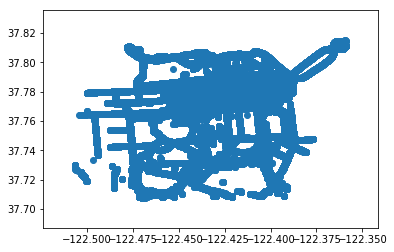

In [49]:
plt.scatter(ldn_76[:,0], ldn_76[:,1])

In [62]:
# This method works pretty well, but I'm going to used just the polygon outline pts for now

import random
from shapely.geometry import Point
def generate_random(number, polygon):
    list_of_points = []
    minx, miny, maxx, maxy = polygon.bounds
    counter = 0
    while counter < number:
        pnt = Point(random.uniform(minx, maxx), random.uniform(miny, maxy))
        if polygon.contains(pnt):
            list_of_points.append(pnt)
            counter += 1
    return list_of_points

In [50]:
# tmp2 = []
# for item in tmp:
#     tmp2.append([item.xy[0].tolist()[0], item.xy[1].tolist()[0]])

In [51]:
# plt.scatter(np.array(tmp2)[:,0], np.array(tmp2)[:,1])
# plt.xlim((-122.46018, -122.46016))
# plt.ylim((37.73520, 37.73523))
# test.iloc[0].geometry;

## Airbnb preliminary data treatment

The goal is to clean the Airbnb datasets then combine the calendar df (which includes prices) with the listings df and the reviews df. This combined Airbnb dataset will then be used to build, train, and test a preliminary pricing model for rentals.

Much of the data still need to be converted to numeric types. Need to also check if all listing ids match across the various tables. Would be great to do some NLP on the reviews and maybe listing info. I am assuming that the listing info provided by owners is going to be from a rose-colored glasses perspective, but might still be useful.

There is a lot of other information that could be combined with this to make a more robust model, but it will be good to establish a baseline first. Also, there are still somethings that need to be hammered out, like how the prices could changes depending on the date of the rental - for now I may just assign a rental rate that is the mean of all of the prices through the year (i.e. not just a mean of the high and low price but a mean over all of the days the listing is available for rent).

In [41]:
print 'Number or listings ids in "calendar": {}'.format(len(bnb_cal.listing_id.unique()))
print 'Number or listings ids in "listings": {}'.format(len(bnb_listings.id.unique()))
print 'Number or listings ids in "reviews": {}'.format(len(bnb_reviews.listing_id.unique()))


Number or listings ids in "calendar": 8619
Number or listings ids in "listings": 8619
Number or listings ids in "reviews": 6396


It appears that there are not reviews for every listing, this could be because some of them are new listings or people signed up but never actually listed their units. For most of the listings there are many reviews that need to be coalesced for word analysis. Listings that are missing reviews may have never had guests, for one reason or another.

In [42]:
bnb_reviews[bnb_reviews.listing_id == 3320213]

listing_id        id        date  reviewer_id      reviewer_name  \
1      3320213  14805088  2014-06-26     17101713               Faye   
2      3320213  17192435  2014-08-08       182792  Jocelyne & Pontus   
3      3320213  17597907  2014-08-14     19649465          Francesco   
4      3320213  18293826  2014-08-24      1104165             Daniel   
5      3320213  18602107  2014-08-28     20421291             Dervla   
6      3320213  18962894  2014-09-03      5356869               Lily   
7      3320213  19856731  2014-09-19      4522712                Eli   
8      3320213  20627838  2014-10-02     21535655             Sergiu   
9      3320213  20802533  2014-10-05     21988006            Kenneth   
10     3320213  21475691  2014-10-18     21643735             Joanna   
11     3320213  23934713  2014-12-14     24770822             Hayley   
12     3320213  24214582  2014-12-22     24971944               Dash   
13     3320213  24350459  2014-12-26     14470174             Smitha   
14     3320213  24690878  2015-01-01     25140184            Madelin   
15     3320213  26577293  2015-02-15     26226029             George   
16     3320213  27973730  2015-03-15     29050391              Wadih   
17     3320213  28640830  2015-03-27     11465559              Diana   
18     3320213  29079110  2015-04-03      2771864             Daniel   
19     3320213  29573423  2015-04-09      3202389              Aaron   
20     3320213  29706726  2015-04-11     30601639              Leroy   
21     3320213  29956701  2015-04-14     30944414               Leah   
22     3320213  30338006  2015-04-20     28559961               Kate   
23     3320213  32008819  2015-05-12      8946146              Katie   
24     3320213  32192410  2015-05-15     16307004             Collin   
25     3320213  33053535  2015-05-24      3121482                Les   
26     3320213  33412618  2015-05-27       510171              Reema   
27     3320213  36354263  2015-06-27      6836324              Pilar   
28     3320213  36404148  2015-06-28     13065529                 Mo   
29     3320213  50370405  2015-10-11     45328245             Cyntia   

                                             comments  
1   The place was clean and spacious and the guy t...  
2   This place wasn't as pleasant as we hoped. Had...  
3   Si tratta di una piccola pensione/albergo.\nSt...  
4   Nice room, cool neighbourhood. Note that this ...  
5   The listing was accurate and the location was ...  
6                                     Great location!  
7   There is very little host interaction since yo...  
8   Very good place. It is very clean and quiet. I...  
9   Great location, comfy room. Accommodating host...  
10  Note that this room is in an actual hotel. It ...  
11  Great location. There are a lot of good places...  
12                     Nice place, cool part of town   
13                            Comfy, worth the price!  
14  Room was in a hotel, small rooms with Hawaiian...  
15  Great place. Located centrally in the Mission....  
16  Stayed there with a couple of friends.\nThe ho...  
17  It's a walk up so if you have a ton of luggage...  
18  Great stay with a central location. The room w...  
19  This location is fantastic. It's basically a H...  
20  The hotel is located on a medium busy street w...  
21  The room is actually in a hotel, which is not ...  
22  Great value for San Francisco! The rooms were ...  
23  Great location, clean, safe, and affordable. O...  
24                     It was clean. Great location.   
25  Unfortunately we did not get a chance to stay ...  
26  It's not the best motel in town.  Smelled like...  
27                LOCATION, LOCARION, LOCATION!!! : )  
28  Two of my friends got rash from sitting on the...  
29  I tried to confirm my stay multiple times, mad...

First, I need to deal with the prices from the calendar table, which need to be grouped by id, aggregating the prices by taking the mean for each listing. The listings summary table actually has pricing information for each listing but I want to see if those prices are consistent and take into account the vairable rate that some people charge for their rentals.

In [43]:
bnb_listings_sum.id.unique().shape

(8619,)

In [44]:
cal_mean_prices = bnb_cal.groupby("listing_id")[["price"]].mean()
cal_mean_prices.reset_index(inplace=True)
cal_mean_prices.tail()

listing_id      price
8614    13801466  55.000000
8615    13802849  61.071429
8616    13802856  75.000000
8617    13803228        NaN
8618    13803588  60.000000

In [45]:
bnb_listings_sum[bnb_listings_sum.id == 13803228]

id                          name   host_id host_name  \
1037  13803228  Fab Mid-Century Master Suite  79745762      Troy   

      neighbourhood_group    neighbourhood   latitude   longitude  \
1037                  NaN  Diamond Heights  37.746253 -122.444623   

         room_type  price  minimum_nights  number_of_reviews last_review  \
1037  Private room    195               2                  0         NaN   

      reviews_per_month  calculated_host_listings_count  availability_365  
1037                NaN                               1                 0

Some of the units that don't have any prices listed in the calendar have prices given in the listings summary table. Need to decide what to do about this - it's pretty clear that people may have stopped making their units available for rent (missing from calendar availibility) even though they still have a rental profile/summary available in the listings summary table.

In [46]:
bnb_listings.T

0     \
id                                                                         11187767   
listing_url                                   https://www.airbnb.com/rooms/11187767   
scrape_id                                                            20160702162156   
last_scraped                                                             2016-07-02   
name                                             Huge Seacliff Penthouse With Views   
summary                           Amazing views from this immense 3 bedroom/ 2 b...   
space                             Spacious patio deck, library with over 300 mov...   
description                       Amazing views from this immense 3 bedroom/ 2 b...   
experiences_offered                                                            none   
neighborhood_overview             The neighborhood includes Legion of Honor, Sut...   
notes                             We require a separate rental agreement to be s...   
transit                           Public Transportation including Muni and the B...   
access                            Guests have access to the entire flat includin...   
interaction                         I am available 24 hours a day during your stay.   
house_rules                       1. Smoking is NOT allowed in the Property, Com...   
thumbnail_url                     https://a2.muscache.com/im/pictures/e8652800-a...   
medium_url                        https://a2.muscache.com/im/pictures/e8652800-a...   
picture_url                       https://a2.muscache.com/im/pictures/e8652800-a...   
xl_picture_url                    https://a2.muscache.com/im/pictures/e8652800-a...   
host_id                                                                    58242037   
host_url                                 https://www.airbnb.com/users/show/58242037   
host_name                                                                  Jonathan   
host_since                                                               2016-02-10   
host_location                              San Francisco, California, United States   
host_about                        Property Manager for Watt Property Management,...   
host_response_time                                                   within an hour   
host_response_rate                                                             100%   
host_acceptance_rate                                                           100%   
host_is_superhost                                                                 f   
host_thumbnail_url                https://a2.muscache.com/im/pictures/351d2fbc-4...   
...                                                                             ...   
guests_included                                                                   1   
extra_people                                                                  $0.00   
minimum_nights                                                                    2   
maximum_nights                                                                   28   
calendar_updated                                                              today   
has_availability                                                                NaN   
availability_30                                                                   8   
availability_60                                                                  31   
availability_90                                                                  61   
availability_365                                                                152   
calendar_last_scraped                                                    2016-07-02   
number_of_reviews                                                                 3   
first_review                                                             2016-03-23   
last_review                                                              2016-06-25   
review_scores_rating                                                         

In [47]:
listing_cols = bnb_listings.columns.values

Merge summary table with the prices calculated from the calendar table.

In [48]:
cal_sum = bnb_listings_sum.merge(cal_mean_prices, left_on="id", right_on="listing_id", how='left')
cal_sum['price_mod'] = cal_sum.price_y.values
cal_sum.price_mod.fillna(cal_sum['price_x'], inplace=True)
price_cut = cal_sum[['id', 'price_y', 'price_mod']]
cal_sum.head(1)

id                                name   host_id host_name  \
0  11187767  Huge Seacliff Penthouse With Views  58242037  Jonathan   

   neighbourhood_group neighbourhood   latitude   longitude        room_type  \
0                  NaN      Seacliff  37.779685 -122.510472  Entire home/apt   

   price_x  minimum_nights  number_of_reviews last_review  reviews_per_month  \
0      400               2                  3  2016-06-25               0.88   

   calculated_host_listings_count  availability_365  listing_id     price_y  \
0                               1               152    11187767  497.368421   

    price_mod  
0  497.368421

Almost all of the columns from the summary table are present in the listings table already. Therefore, I can extract the two price columns (including the one I created) and merge them with the full listings table.

In [49]:
room_type = bnb_listings[['id', 'room_type']]
room_type = pd.get_dummies(room_type, columns=['room_type'])
room_type.rename(columns={"room_type_Entire home/apt": 'entire_home_apt', 'room_type_Private room': 'private_room',
                          'room_type_Shared room': 'shared_room'}, inplace=True)

prop_type = bnb_listings[['id', 'property_type']]
prop_type = pd.get_dummies(prop_type, columns=['property_type'])
prop_type.rename(columns={'property_type_Apartment': 'apartment', 'property_type_Bed & Breakfast': 'bed_breakfast',
                          'property_type_Boat': 'boat', 'property_type_Bungalow': 'bungalow', 
                          'property_type_Cabin': 'cabin', 'property_type_Camper/RV': 'camper_rv', 
                          'property_type_Castle': 'castle', 'property_type_Cave': 'cave', 
                          'property_type_Condominium': 'codominium', 'property_type_Dorm': 'dorm', 
                          'property_type_House': 'house', 'property_type_Lighthouse': 'lighthouse', 
                          'property_type_Loft': 'loft', 'property_type_Other': 'other', 
                          'property_type_Tent': 'tent', 'property_type_Townhouse': 'townhouse', 
                          'property_type_Treehouse': 'treehouse', 'property_type_Villa': 'villa', 
                          'property_type_Yurt': 'yurt'}, inplace=True)

In [50]:
bnb_list_full = bnb_listings.merge(price_cut, on='id', how='left')
bnb_list_full = bnb_list_full.merge(room_type, on='id', how='left')
bnb_list_full = bnb_list_full.merge(prop_type, on='id', how='left')
bnb_list_full.review_scores_rating.fillna(bnb_list_full.review_scores_rating.mean(), inplace=True)
bnb_list_full.review_scores_accuracy.fillna(bnb_list_full.review_scores_accuracy.mean(), inplace=True)
bnb_list_full.review_scores_cleanliness.fillna(bnb_list_full.review_scores_cleanliness.mean(), inplace=True)
bnb_list_full.review_scores_checkin.fillna(bnb_list_full.review_scores_checkin.mean(), inplace=True)
bnb_list_full.review_scores_communication.fillna(bnb_list_full.review_scores_communication.mean(), inplace=True)
bnb_list_full.review_scores_location.fillna(bnb_list_full.review_scores_location.mean(), inplace=True)
bnb_list_full.review_scores_value.fillna(bnb_list_full.review_scores_value.mean(), inplace=True)

bnb_list_full.T

0     \
id                                                                         11187767   
listing_url                                   https://www.airbnb.com/rooms/11187767   
scrape_id                                                            20160702162156   
last_scraped                                                             2016-07-02   
name                                             Huge Seacliff Penthouse With Views   
summary                           Amazing views from this immense 3 bedroom/ 2 b...   
space                             Spacious patio deck, library with over 300 mov...   
description                       Amazing views from this immense 3 bedroom/ 2 b...   
experiences_offered                                                            none   
neighborhood_overview             The neighborhood includes Legion of Honor, Sut...   
notes                             We require a separate rental agreement to be s...   
transit                           Public Transportation including Muni and the B...   
access                            Guests have access to the entire flat includin...   
interaction                         I am available 24 hours a day during your stay.   
house_rules                       1. Smoking is NOT allowed in the Property, Com...   
thumbnail_url                     https://a2.muscache.com/im/pictures/e8652800-a...   
medium_url                        https://a2.muscache.com/im/pictures/e8652800-a...   
picture_url                       https://a2.muscache.com/im/pictures/e8652800-a...   
xl_picture_url                    https://a2.muscache.com/im/pictures/e8652800-a...   
host_id                                                                    58242037   
host_url                                 https://www.airbnb.com/users/show/58242037   
host_name                                                                  Jonathan   
host_since                                                               2016-02-10   
host_location                              San Francisco, California, United States   
host_about                        Property Manager for Watt Property Management,...   
host_response_time                                                   within an hour   
host_response_rate                                                             100%   
host_acceptance_rate                                                           100%   
host_is_superhost                                                                 f   
host_thumbnail_url                https://a2.muscache.com/im/pictures/351d2fbc-4...   
...                                                                             ...   
instant_bookable                                                                  t   
cancellation_policy                                                          strict   
require_guest_profile_picture                                                     f   
require_guest_phone_verification                                                  f   
calculated_host_listings_count                                                    1   
reviews_per_month                                                              0.88   
price_y                                                                     497.368   
price_mod                                                                   497.368   
entire_home_apt                                                                   1   
private_room                                                                      0   
shared_room                                                                       0   
apartment                                                                         0   
bed_breakfast                                                                     0   
boat                                                                              0   
bungalow                                                                     

Need to convert some of the money features into float data types. Quick function below to convert the dollar columns to floats.

In [51]:
bnb_list_full = conv_dollars(bnb_list_full, ['price', 'weekly_price', 'monthly_price', 
                                             'security_deposit', 'cleaning_fee', 'extra_people'])
bnb_list_full.tail(60).T

8559  \
id                                                                          1370128   
listing_url                                    https://www.airbnb.com/rooms/1370128   
scrape_id                                                            20160702162156   
last_scraped                                                             2016-07-02   
name                                             Hidden Gem in Locals' Neighborhood   
summary                                                                         NaN   
space                             ABOUT THE SPACE This beautiful room in a dog-f...   
description                       ABOUT THE SPACE This beautiful room in a dog-f...   
experiences_offered                                                            none   
neighborhood_overview                                                           NaN   
notes                                                                           NaN   
transit                                                                         NaN   
access                                                                          NaN   
interaction                                                                     NaN   
house_rules                                                                     NaN   
thumbnail_url                     https://a1.muscache.com/im/pictures/20731426/d...   
medium_url                        https://a1.muscache.com/im/pictures/20731426/d...   
picture_url                       https://a1.muscache.com/im/pictures/20731426/d...   
xl_picture_url                    https://a1.muscache.com/im/pictures/20731426/d...   
host_id                                                                     4510183   
host_url                                  https://www.airbnb.com/users/show/4510183   
host_name                                                                    Andrea   
host_since                                                               2012-12-27   
host_location                              San Francisco, California, United States   
host_about                        Hi all!\r\nI love living in San Francisco. I'm...   
host_response_time                                                   within an hour   
host_response_rate                                                              93%   
host_acceptance_rate                                                            96%   
host_is_superhost                                                                 f   
host_thumbnail_url                https://a0.muscache.com/im/users/4510183/profi...   
...                                                                             ...   
instant_bookable                                                                  f   
cancellation_policy                                                        moderate   
require_guest_profile_picture                                                     f   
require_guest_phone_verification                                                  f   
calculated_host_listings_count                                                    1   
reviews_per_month                                                                 3   
price_y                                                                     218.235   
price_mod                                                                   218.235   
entire_home_apt                                                                   1   
private_room                                                                      0   
shared_room                                                                       0   
apartment                                                                         1   
bed_breakfast                                                                     0   
boat                                                                              0   
bungalow                                                                     

Could use bed_type and amenities if I wanted to generate more features from categorical values. Converted room_type and proper_type to categorical feature columns with boolean values. This could possibly be restructured with a different method or changed to a more appropriate method that takes into account for categories that are rare (sparse columns when using boolean values).

Square_feet would be a great predictor to use, and will likely be availabe with real estate listings, should consider this a large caveat.

Some listings have never been reviewed, which represents a bit of a challenge considering they are valueable pieces of data I don't want to simply discard. For now I will impute mean rating values for each column into missing values (NaNs).

There are also 4 or 5 listings that I know are fake and have large prices that are probably throwing off the model. I am going to cut these out by their listing_id.

In [52]:
#print bnb_list_full[bnb_list_full.id == 5241594]
bnb_list_full[bnb_list_full.price == 1500]

id                            listing_url       scrape_id  \
358    8993733   https://www.airbnb.com/rooms/8993733  20160702162156   
592   10920486  https://www.airbnb.com/rooms/10920486  20160702162156   
693   11023311  https://www.airbnb.com/rooms/11023311  20160702162156   
1526  10638176  https://www.airbnb.com/rooms/10638176  20160702162156   
1844  10541422  https://www.airbnb.com/rooms/10541422  20160702162156   
2423  10846683  https://www.airbnb.com/rooms/10846683  20160702162156   
2679   8973469   https://www.airbnb.com/rooms/8973469  20160702162156   
2711  10789325  https://www.airbnb.com/rooms/10789325  20160702162156   
3017  10766464  https://www.airbnb.com/rooms/10766464  20160702162156   
3277  11046897  https://www.airbnb.com/rooms/11046897  20160702162156   
3435  10206402  https://www.airbnb.com/rooms/10206402  20160702162156   
3608  10769149  https://www.airbnb.com/rooms/10769149  20160702162156   
4109   7003729   https://www.airbnb.com/rooms/7003729  20160702162156   
4131   1291092   https://www.airbnb.com/rooms/1291092  20160702162156   
4170  10788537  https://www.airbnb.com/rooms/10788537  20160702162156   
4650  10635240  https://www.airbnb.com/rooms/10635240  20160702162156   
4794   8673679   https://www.airbnb.com/rooms/8673679  20160702162156   
4856    424082    https://www.airbnb.com/rooms/424082  20160702162156   
5126   1179825   https://www.airbnb.com/rooms/1179825  20160702162156   
5222  10808180  https://www.airbnb.com/rooms/10808180  20160702162156   
5405  12891102  https://www.airbnb.com/rooms/12891102  20160702162156   
5693  10854509  https://www.airbnb.com/rooms/10854509  20160702162156   
6035  11682275  https://www.airbnb.com/rooms/11682275  20160702162156   
6237   9713928   https://www.airbnb.com/rooms/9713928  20160702162156   
6363  10705958  https://www.airbnb.com/rooms/10705958  20160702162156   
7001  10840730  https://www.airbnb.com/rooms/10840730  20160702162156   
7051  10827305  https://www.airbnb.com/rooms/10827305  20160702162156   
7206   1961076   https://www.airbnb.com/rooms/1961076  20160702162156   
7387   6492391   https://www.airbnb.com/rooms/6492391  20160702162156   
8115   4033038   https://www.airbnb.com/rooms/4033038  20160702162156   
8232  10704489  https://www.airbnb.com/rooms/10704489  20160702162156   

     last_scraped                                               name  \
358    2016-07-02                   SuperBowl Week - Stunning Views!   
592    2016-07-02                   Two bedroom one bath in law apt.   
693    2016-07-02                     Duplex Apt w/ Private Backyard   
1526   2016-07-02                   SB50! Huge, Sunny Noe Valley 2BR   
1844   2016-07-02                              Nature in heart of SF   
2423   2016-07-02                 The Ritz-Carlton Club & Residences   
2679   2016-07-02                Classic SF Victorian in Noe/Mission   
2711   2016-07-02                 New Valencia Condo w/ Private Roof   
3017   2016-07-02                      Superbowl home away from home   
3277   2016-07-02                3bed/2bath Spacious flat near BART!   
3435   2016-07-02                   Superbowl Apartment with Parking   
3608   2016-07-02                       Your Mission Super Bowl Home   
4109   2016-07-02                        Cow Hollow Sunny, View Home   
4131   2016-07-02                   Gorgeous 3 bd Home in the Marina   
4170   2016-07-02                State of the art home in Cow Hollow   
4650   2016-07-02                           Spacious remodeled home!   
4794   2016-07-02                    Best apartment in San Francisco   
4856   2016-07-02                Modern condo on the water downtown!   
5126   2016-07-02                            Stunning Warehouse Loft   
5222   2016-07-02                    NATOMA - Luxury Downtown SF Apt   
5405   2016-07-02     2000 Square Feet of Loft Goodness for meetings   
5693   2016-07-02                            Super Bowl Potrero home   
6035   2016-07-02  

In [53]:
# used this for finding fake listings and other outliers in the dataset
bnb_list_full[bnb_list_full['summary'].str.contains(r"bowl", na=False)]

id                            listing_url       scrape_id  \
391   13772008  https://www.airbnb.com/rooms/13772008  20160702162156   
430      72205     https://www.airbnb.com/rooms/72205  20160702162156   
447   10917847  https://www.airbnb.com/rooms/10917847  20160702162156   
615   10383517  https://www.airbnb.com/rooms/10383517  20160702162156   
693   11023311  https://www.airbnb.com/rooms/11023311  20160702162156   
837   11048476  https://www.airbnb.com/rooms/11048476  20160702162156   
916   10517656  https://www.airbnb.com/rooms/10517656  20160702162156   
930    8257534   https://www.airbnb.com/rooms/8257534  20160702162156   
949   10825963  https://www.airbnb.com/rooms/10825963  20160702162156   
951    7024670   https://www.airbnb.com/rooms/7024670  20160702162156   
958    9858200   https://www.airbnb.com/rooms/9858200  20160702162156   
1008  10770909  https://www.airbnb.com/rooms/10770909  20160702162156   
1015  10836765  https://www.airbnb.com/rooms/10836765  20160702162156   
1053  10910661  https://www.airbnb.com/rooms/10910661  20160702162156   
1242  10964074  https://www.airbnb.com/rooms/10964074  20160702162156   
1294  11085405  https://www.airbnb.com/rooms/11085405  20160702162156   
1319   9280852   https://www.airbnb.com/rooms/9280852  20160702162156   
1511   1332629   https://www.airbnb.com/rooms/1332629  20160702162156   
1533  10923676  https://www.airbnb.com/rooms/10923676  20160702162156   
2432  10900338  https://www.airbnb.com/rooms/10900338  20160702162156   
2435  10851860  https://www.airbnb.com/rooms/10851860  20160702162156   
2679   8973469   https://www.airbnb.com/rooms/8973469  20160702162156   
2813  10681830  https://www.airbnb.com/rooms/10681830  20160702162156   
3122  10473103  https://www.airbnb.com/rooms/10473103  20160702162156   
4009  10860614  https://www.airbnb.com/rooms/10860614  20160702162156   
4208  10879152  https://www.airbnb.com/rooms/10879152  20160702162156   
4239  10882774  https://www.airbnb.com/rooms/10882774  20160702162156   
4321  10731420  https://www.airbnb.com/rooms/10731420  20160702162156   
4361  10756223  https://www.airbnb.com/rooms/10756223  20160702162156   
4416  10073786  https://www.airbnb.com/rooms/10073786  20160702162156   
...        ...                                    ...             ...   
5027  10906832  https://www.airbnb.com/rooms/10906832  20160702162156   
5114  11023980  https://www.airbnb.com/rooms/11023980  20160702162156   
5124  10880931  https://www.airbnb.com/rooms/10880931  20160702162156   
5145  10931258  https://www.airbnb.com/rooms/10931258  20160702162156   
5267  11014352  https://www.airbnb.com/rooms/11014352  20160702162156   
5322  10766524  https://www.airbnb.com/rooms/10766524  20160702162156   
5437  10889013  https://www.airbnb.com/rooms/10889013  20160702162156   
5506   5807223   https://www.airbnb.com/rooms/5807223  20160702162156   
5708  10356383  https://www.airbnb.com/rooms/10356383  20160702162156   
5713  10749855  https://www.airbnb.com/rooms/10749855  20160702162156   
5716    935967    https://www.airbnb.com/rooms/935967  20160702162156   
5730  10772943  https://www.airbnb.com/rooms/10772943  20160702162156   
5836  10553331  https://www.airbnb.com/rooms/10553331  20160702162156   
5876  10770929  https://www.airbnb.com/rooms/10770929  20160702162156   
6028  10473301  https://www.airbnb.com/rooms/10473301  20160702162156   
6929  10942415  https://www.airbnb.com/rooms/10942415  20160702162156   
6956   9342219   https://www.airbnb.com/rooms/9342219  20160702162156   
7001  10840730  https://www.airbnb.com/rooms/10840730  20160702162156   
7031  10594745  https://www.airbnb.com/rooms/10594745  20160702162156   
7045    794815    https://www.airbnb.com/rooms/794815  20160702162156   
7104  10930621  https://www.airbnb.com/rooms/10930621  20160702162156   
7124  10961121  https://www.airbnb.com/rooms/10961121  20160702162156   
7319  10930264  https://www.airbnb.com/rooms/10930264  20160702162156 

In [54]:
# These are a collection of fake listings and other rentals that are extreme outliers
fake_listings = [2417349, 13187104, 13086674, 10724176,  11671456, 8614819,
                 12756507, 10929043, 11993313, 900485, 8703269, 9939073, 13205424, 
                 8353194, 5241594, 10926089, 9978975, 10926823, 7181467, 12605137, 
                 10962521, 9394422, 8993733, 2970867, 9880181, 10766464, 10854509, 
                 10840730, 1961076, 6492391, 10920486, 11023311, 10206402,11046897, 
                 10769149, 10846683, 8257534, 10383517, 10917847, 10836765, 10910661, 
                 11085405, 9280852, 1332629, 10923676, 10900338, 10879152, 10073786, 
                 10880931, 10931258, 11014352, 10766524, 10889013, 935967, 10553331, 
                 9342219, 10930264, 10811617, 10998170, 10788444]

for item in fake_listings:
    bnb_list_full = bnb_list_full[bnb_list_full.id != item]

In [55]:
bnb_list_full.columns.values

array(['id', 'listing_url', 'scrape_id', 'last_scraped', 'name', 'summary',
       'space', 'description', 'experiences_offered',
       'neighborhood_overview', 'notes', 'transit', 'access',
       'interaction', 'house_rules', 'thumbnail_url', 'medium_url',
       'picture_url', 'xl_picture_url', 'host_id', 'host_url', 'host_name',
       'host_since', 'host_location', 'host_about', 'host_response_time',
       'host_response_rate', 'host_acceptance_rate', 'host_is_superhost',
       'host_thumbnail_url', 'host_picture_url', 'host_neighbourhood',
       'host_listings_count', 'host_total_listings_count',
       'host_verifications', 'host_has_profile_pic',
       'host_identity_verified', 'street', 'neighbourhood',
       'neighbourhood_cleansed', 'neighbourhood_group_cleansed', 'city',
       'state', 'zipcode', 'market', 'smart_location', 'country_code',
       'country', 'latitude', 'longitude', 'is_location_exact',
       'property_type', 'room_type', 'accommodates', 'bathrooms',

In [56]:
num_cols = ['id','host_total_listings_count','latitude', 'longitude', 'accommodates', 'bathrooms',
            'bedrooms', 'beds', 'amenities', 'price','guests_included', 'extra_people', 
            'minimum_nights','maximum_nights',
            'availability_30', 'availability_60', 'availability_90', 'availability_365', 
            'number_of_reviews', 'review_scores_rating','review_scores_accuracy', 
            'review_scores_cleanliness','review_scores_checkin', 'review_scores_communication',
            'review_scores_location', 'review_scores_value', 'calculated_host_listings_count', 
            'reviews_per_month', 'price_y', 'price_mod', 'entire_home_apt', 'private_room', 
            'shared_room', 'apartment', 'bed_breakfast', 'boat', 'bungalow', 'cabin',
            'camper_rv', 'castle', 'cave', 'codominium', 'dorm', 'house','lighthouse', 'loft', 
            'other', 'tent', 'townhouse', 'treehouse', 'villa', 'yurt']
bnb_list_full =  bnb_list_full[num_cols + ['neighbourhood_cleansed']]


One hot encode neighbourhood_cleansed feature.

In [57]:
neigh_dummies = pd.get_dummies(bnb_list_full.neighbourhood_cleansed)
bnb_list_full = pd.concat([bnb_list_full[num_cols], neigh_dummies], axis=1)

In [58]:
bnb_list_full

id  host_total_listings_count   latitude   longitude  \
0     11187767                        1.0  37.779685 -122.510472   
1      6938818                        2.0  37.780659 -122.505635   
2      9395222                        2.0  37.781433 -122.505179   
3      8388658                        1.0  37.787664 -122.489152   
4      7856443                        2.0  37.782133 -122.492730   
5      4781448                        2.0  37.781797 -122.492492   
6      1427660                        1.0  37.775236 -122.509137   
7      8087607                        2.0  37.775318 -122.511621   
8      9904485                        2.0  37.785487 -122.488011   
9      3168359                        2.0  37.779319 -122.509635   
10    10961737                        1.0  37.785566 -122.488729   
11       69681                       43.0  37.777069 -122.509232   
12     1931937                        2.0  37.781564 -122.494424   
13     2134100                        1.0  37.783888 -122.508557   
14     9824673                        1.0  37.781804 -122.507327   
15     8001958                        1.0  37.780708 -122.509160   
16     8411606                        1.0  37.784886 -122.492872   
17     5218679                        2.0  37.769947 -122.448193   
18     8084655                        1.0  37.772623 -122.448144   
19    11169698                        1.0  37.769497 -122.453197   
20     1605483                        1.0  37.765510 -122.449460   
21     6812162                        1.0  37.767632 -122.450091   
22     1827776                      346.0  37.766616 -122.442278   
23    12857736                        1.0  37.776149 -122.439072   
24     5320351                        1.0  37.774748 -122.442120   
25     3138935                        1.0  37.774244 -122.451590   
26    10988856                        4.0  37.775223 -122.444716   
27    10733204                        1.0  37.775553 -122.441938   
28      911029                        1.0  37.762840 -122.446241   
29      449532                        5.0  37.771395 -122.440504   
...        ...                        ...        ...         ...   
8589   5258355                        1.0  37.776322 -122.446189   
8590   6575965                        1.0  37.773001 -122.437430   
8591  11016248                        5.0  37.776658 -122.445012   
8592   1627946                        1.0  37.774710 -122.431518   
8593  12212013                        1.0  37.776175 -122.432171   
8594   6729923                        3.0  37.775824 -122.423508   
8595    808660                        1.0  37.784603 -122.443887   
8596   7227859                        7.0  37.786111 -122.440192   
8597   4616783                        1.0  37.774216 -122.427054   
8598   6272183                        1.0  37.769802 -122.472160   
8599   3319447                        1.0  37.766516 -122.456014   
8600   2694526                        5.0  37.772556 -122.458669   
8601  10936828                        1.0  37.765627 -122.483467   
8602    254953                        4.0  37.770271 -122.510905   
8603   2397858                        2.0  37.770261 -122.499015   
8604   9318994                        1.0  37.768756 -122.512968   
8605  12753688                        4.0  37.770660 -122.511687   
8606  13661411                        6.0  37.704522 -122.464643   
8607  13452434                        1.0  37.707406 -122.450857   
8608  13661054                        6.0  37.706395 -122.463281   
8609  13786383                        1.0  37.708064 -122.432635   
8610  13478781                        1.0  37.811505 -122.409589   
8611  13661869                        6.0  37.705302 -122.463284   
8612  13397630                        1.0  37.705383 -122.480049   
8613  13674541                       37.0  37.705449 -122.464713   
8614  13493466                        3.0  37.780753 -122.385530   
8615  13684317                       37.0  37.704881 -122.465072   


Fill some missing values with logical replacements.
    
- 2 missing from host_total_listings_count - replace with 1
- 48 missing from bathrooms - replace with 1, considering there is likely a bathroom somewhere
- 6 missing from bedrooms - replace with 0, there probably isn't an actual bed, maybe something to sleep on
- 10 missing from beds - replace with 1, there is probably somewhere to sleep, but maybe not much
- 8417 missing from square_feet - removed feature - would certainly be useful in actual real estate listings
- 2223 missing from reviews_per_month - replace with 0, since there are probably no or very few reviews

In [59]:
bnb_list_full.host_total_listings_count.fillna(1, inplace=True)
bnb_list_full.bathrooms.fillna(0, inplace=True)
bnb_list_full.bedrooms.fillna(0, inplace=True)
#bnb_list_full.beds.dropna(inplace=True)
bnb_list_full = bnb_list_full[bnb_list_full.beds > 0]
bnb_list_full = bnb_list_full[bnb_list_full.bedrooms > 0]
# bnb_list_full[[x for x in bnb_list_full.columns.values if x != 'square_feet']]
bnb_list_full.reviews_per_month.fillna(0, inplace=True)
#bnb_list_full[bnb_list_full.beds == 0].beds.value_counts()

In [60]:
print bnb_list_full.shape
bnb_list_full.isnull().sum()

(7911, 89)


id                                   0
host_total_listings_count            0
latitude                             0
longitude                            0
accommodates                         0
bathrooms                            0
bedrooms                             0
beds                                 0
amenities                            0
price                                0
guests_included                      0
extra_people                         0
minimum_nights                       0
maximum_nights                       0
availability_30                      0
availability_60                      0
availability_90                      0
availability_365                     0
number_of_reviews                    0
review_scores_rating                 0
review_scores_accuracy               0
review_scores_cleanliness            0
review_scores_checkin                0
review_scores_communication          0
review_scores_location               0
review_scores_value      

Neighborhood has a lot to do with the pricing of listings. In order to use this information, I am assigning the census track where each property is located and then I will use the median income for that census track as a new predictor.

In [61]:
bnb_list_full_geo = gpd.GeoDataFrame(bnb_list_full, geometry=bnb_list_full.apply(
        lambda srs: shapely.geometry.Point(srs['longitude'], srs['latitude']), axis='columns'
    ))
bnb_list_full_geo['census_tract'] = bnb_list_full_geo.apply(assign_census_tract, axis='columns')
bnb_list_full_geo


id  host_total_listings_count   latitude   longitude  \
0     11187767                        1.0  37.779685 -122.510472   
1      6938818                        2.0  37.780659 -122.505635   
2      9395222                        2.0  37.781433 -122.505179   
3      8388658                        1.0  37.787664 -122.489152   
4      7856443                        2.0  37.782133 -122.492730   
5      4781448                        2.0  37.781797 -122.492492   
6      1427660                        1.0  37.775236 -122.509137   
7      8087607                        2.0  37.775318 -122.511621   
8      9904485                        2.0  37.785487 -122.488011   
9      3168359                        2.0  37.779319 -122.509635   
10    10961737                        1.0  37.785566 -122.488729   
11       69681                       43.0  37.777069 -122.509232   
12     1931937                        2.0  37.781564 -122.494424   
14     9824673                        1.0  37.781804 -122.507327   
16     8411606                        1.0  37.784886 -122.492872   
17     5218679                        2.0  37.769947 -122.448193   
18     8084655                        1.0  37.772623 -122.448144   
19    11169698                        1.0  37.769497 -122.453197   
20     1605483                        1.0  37.765510 -122.449460   
21     6812162                        1.0  37.767632 -122.450091   
22     1827776                      346.0  37.766616 -122.442278   
23    12857736                        1.0  37.776149 -122.439072   
24     5320351                        1.0  37.774748 -122.442120   
25     3138935                        1.0  37.774244 -122.451590   
26    10988856                        4.0  37.775223 -122.444716   
27    10733204                        1.0  37.775553 -122.441938   
28      911029                        1.0  37.762840 -122.446241   
29      449532                        5.0  37.771395 -122.440504   
30     8811090                        1.0  37.762486 -122.450017   
31     5730174                        2.0  37.769859 -122.441850   
...        ...                        ...        ...         ...   
8587   1103797                        1.0  37.785206 -122.442787   
8588   8869806                        2.0  37.772213 -122.432359   
8589   5258355                        1.0  37.776322 -122.446189   
8590   6575965                        1.0  37.773001 -122.437430   
8591  11016248                        5.0  37.776658 -122.445012   
8592   1627946                        1.0  37.774710 -122.431518   
8594   6729923                        3.0  37.775824 -122.423508   
8595    808660                        1.0  37.784603 -122.443887   
8596   7227859                        7.0  37.786111 -122.440192   
8597   4616783                        1.0  37.774216 -122.427054   
8598   6272183                        1.0  37.769802 -122.472160   
8600   2694526                        5.0  37.772556 -122.458669   
8601  10936828                        1.0  37.765627 -122.483467   
8602    254953                        4.0  37.770271 -122.510905   
8603   2397858                        2.0  37.770261 -122.499015   
8604   9318994                        1.0  37.768756 -122.512968   
8605  12753688                        4.0  37.770660 -122.511687   
8606  13661411                        6.0  37.704522 -122.464643   
8607  13452434                        1.0  37.707406 -122.450857   
8608  13661054                        6.0  37.706395 -122.463281   
8609  13786383                        1.0  37.708064 -122.432635   
8610  13478781                        1.0  37.811505 -122.409589   
8611  13661869                        6.0  37.705302 -122.463284   
8612  13397630                        1.0  37.705383 -122.480049   
8613  13674541                       37.0  37.705449 -122.464713   
8614  13493466                        3.0  37.780753 -122.385530   
8615  13684317                       37.0  37.704881 -122.465072   


In [62]:
bnb_list_full_geo = bnb_list_full_geo[bnb_list_full_geo.census_tract.notnull()]
bnb_list_full_geo['census_tract'] = pd.to_numeric(bnb_list_full_geo.census_tract)
bnb_list_full_geo['med_fam_inc_est16'] = bnb_list_full_geo['census_tract'].map(inc_dict)
bnb_list_full_geo['percent_below_poverty'] = bnb_list_full_geo['census_tract'].map(poverty_dict)
bnb_list_full_geo

/Users/taylorkilian/anaconda3/envs/dsi/lib/python2.7/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app
/Users/taylorkilian/anaconda3/envs/dsi/lib/python2.7/site-packages/ipykernel/__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()
/Users/taylorkilian/anaconda3/envs/dsi/lib/python2.7/site-packages/ipykernel/__main__.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_in

id  host_total_listings_count   latitude   longitude  \
0     11187767                        1.0  37.779685 -122.510472   
1      6938818                        2.0  37.780659 -122.505635   
2      9395222                        2.0  37.781433 -122.505179   
3      8388658                        1.0  37.787664 -122.489152   
4      7856443                        2.0  37.782133 -122.492730   
5      4781448                        2.0  37.781797 -122.492492   
6      1427660                        1.0  37.775236 -122.509137   
7      8087607                        2.0  37.775318 -122.511621   
8      9904485                        2.0  37.785487 -122.488011   
9      3168359                        2.0  37.779319 -122.509635   
10    10961737                        1.0  37.785566 -122.488729   
11       69681                       43.0  37.777069 -122.509232   
12     1931937                        2.0  37.781564 -122.494424   
14     9824673                        1.0  37.781804 -122.507327   
16     8411606                        1.0  37.784886 -122.492872   
17     5218679                        2.0  37.769947 -122.448193   
18     8084655                        1.0  37.772623 -122.448144   
19    11169698                        1.0  37.769497 -122.453197   
20     1605483                        1.0  37.765510 -122.449460   
21     6812162                        1.0  37.767632 -122.450091   
22     1827776                      346.0  37.766616 -122.442278   
23    12857736                        1.0  37.776149 -122.439072   
24     5320351                        1.0  37.774748 -122.442120   
25     3138935                        1.0  37.774244 -122.451590   
26    10988856                        4.0  37.775223 -122.444716   
27    10733204                        1.0  37.775553 -122.441938   
28      911029                        1.0  37.762840 -122.446241   
29      449532                        5.0  37.771395 -122.440504   
30     8811090                        1.0  37.762486 -122.450017   
31     5730174                        2.0  37.769859 -122.441850   
...        ...                        ...        ...         ...   
8575  11016265                        5.0  37.776557 -122.445320   
8576   4773949                        1.0  37.786112 -122.437043   
8578   9315067                        1.0  37.780377 -122.432079   
8579    890901                      104.0  37.770238 -122.436205   
8580   3971090                        3.0  37.783060 -122.433631   
8581    890875                        2.0  37.771165 -122.433728   
8582   7278586                        2.0  37.777592 -122.433548   
8583   1682072                        6.0  37.782775 -122.443132   
8584  12294106                        1.0  37.775112 -122.422682   
8585   4511659                        1.0  37.786043 -122.442818   
8587   1103797                        1.0  37.785206 -122.442787   
8588   8869806                        2.0  37.772213 -122.432359   
8589   5258355                        1.0  37.776322 -122.446189   
8590   6575965                        1.0  37.773001 -122.437430   
8591  11016248                        5.0  37.776658 -122.445012   
8592   1627946                        1.0  37.774710 -122.431518   
8594   6729923                        3.0  37.775824 -122.423508   
8595    808660                        1.0  37.784603 -122.443887   
8596   7227859                        7.0  37.786111 -122.440192   
8597   4616783                        1.0  37.774216 -122.427054   
8598   6272183                        1.0  37.769802 -122.472160   
8600   2694526                        5.0  37.772556 -122.458669   
8601  10936828                        1.0  37.765627 -122.483467   
8602    254953                        4.0  37.770271 -122.510905   
8603   2397858                        2.0  37.770261 -122.499015   
8604   9318994                        1.0  37.768756 -122.512968   
8605  12753688                        4.0  37.770660 -122.511687   


In [63]:
bnb_list_full_geo = pd.DataFrame(bnb_list_full_geo)
pd.to_pickle(bnb_list_full_geo, './bnb_list_full_geo')

In [64]:
bnb_list_full_geo = pd.read_pickle('./bnb_list_full_geo')

In [65]:
pd.to_pickle(bnb_list_full, './bnb_list_full')

In [66]:
bnb_list_full = pd.read_pickle('./bnb_list_full')

In [67]:
bnb_list_full.head()

id  host_total_listings_count   latitude   longitude  accommodates  \
0  11187767                        1.0  37.779685 -122.510472             6   
1   6938818                        2.0  37.780659 -122.505635             4   
2   9395222                        2.0  37.781433 -122.505179             4   
3   8388658                        1.0  37.787664 -122.489152             6   
4   7856443                        2.0  37.782133 -122.492730             6   

   bathrooms  bedrooms  beds  \
0        2.0       3.0   3.0   
1        1.0       1.0   2.0   
2        1.0       1.0   2.0   
3        2.5       3.0   4.0   
4        2.5       3.0   4.0   

                                           amenities  price      ...       \
0  {TV,"Cable TV","Wireless Internet",Kitchen,Hea...  400.0      ...        
1  {TV,Internet,"Wireless Internet",Kitchen,Heati...   99.0      ...        
2  {TV,Kitchen,"Free Parking on Premises","Pets A...  155.0      ...        
3  {TV,Internet,"Wireless Internet",Kitchen,"Free...  895.0      ...        
4  {TV,Internet,"Wireless Internet",Kitchen,"Free...  195.0      ...        

   Russian Hill  Seacliff  South of Market  Treasure Island/YBI  Twin Peaks  \
0             0         1                0                    0           0   
1             0         1                0                    0           0   
2             0         1                0                    0           0   
3             0         1                0                    0           0   
4             0         1                0                    0           0   

   Visitacion Valley  West of Twin Peaks  Western Addition  \
0                  0                   0                 0   
1                  0                   0                 0   
2                  0                   0                 0   
3                  0                   0                 0   
4                  0                   0                 0   

                                       geometry  census_tract  
0  POINT (-122.5104716962268 37.77968470054454)        479.01  
1  POINT (-122.5056347793022 37.78065902049909)        479.02  
2  POINT (-122.5051793274895 37.78143337110802)          9802  
3   POINT (-122.489152227618 37.78766423088835)           428  
4  POINT (-122.4927302695125 37.78213277410354)           427  

[5 rows x 91 columns]

Plot map of all rental units.

/Users/taylorkilian/anaconda3/envs/dsi/lib/python2.7/site-packages/mpl_toolkits/basemap/__init__.py:3274: MatplotlibDeprecationWarning: The ishold function was deprecated in version 2.0.
  b = ax.ishold()
/Users/taylorkilian/anaconda3/envs/dsi/lib/python2.7/site-packages/mpl_toolkits/basemap/__init__.py:3283: MatplotlibDeprecationWarning: axes.hold is deprecated.
    See the API Changes document (http://matplotlib.org/api/api_changes.html)
    for more details.
  ax.hold(b)


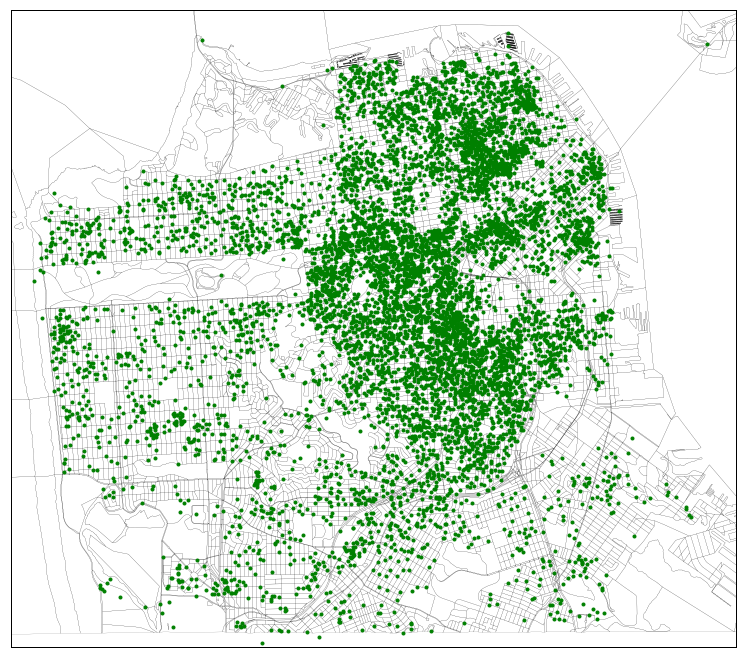

In [75]:
y = bnb_list_full.latitude.values
x = bnb_list_full.longitude.values

plt.figure(figsize=(13,13))
m = Basemap(llcrnrlon=-122.518,llcrnrlat=37.705683,urcrnrlon=-122.36,
            urcrnrlat=37.81534, resolution='l',projection='merc')

m.readshapefile('./map_data/census_blocks/geo_export_7c410ec8-5cfa-4422-9893-1d3d5cf3be1f','sf_blocks', linewidth=.1)

m.drawmapboundary(fill_color='white')

m.plot(x, y, 'go', markersize=3, latlon=True)
#plt.title('contour lines over filled continent background')
plt.savefig('abnb_map.pdf')
plt.show()

It is important to mention that Airbnb anonymizes rental locations by changing them slightly. Overall, the coordinates given are supposedly no more 500 ft or so from the actual location, so it shouldn't matter too much for our analysis. Although, this could create unexpected or unintended interactions witht the geospatial city data.

#### Preliminary modelling of airbnb listing data

In [4]:
# from sklearn.metrics import 
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, RidgeCV, Ridge, LassoCV, Lasso
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor
from xgboost import XGBRegressor
from sklearn.model_selection import GridSearchCV, cross_val_score

import seaborn as sns

In [77]:
def rmse(y_pred, y_true):
    leng = len(y_pred)
    if leng == len(y_true):
        return np.sqrt((1/float(leng)) * np.sum((y_true-y_pred)**2))

Just to test out the predicitve ability of some of the features, I am going t run through some raw tests to predict the price of the airbnb rental at a per night rate. I am going to target the modified prices, prices_mod, which are a combination of the declared rate in the summary table and the calculated per night average rate of prices in an attempt to capture the range of values for weeknights, weekends, and holidays.

We can compare these results to the summary prices, which is another feature in the df.

In [78]:
# Can use this to sort rentals out of the dataset given a certain attribute like reviews/month

# bnb_list_full = bnb_list_full[bnb_list_full.reviews_per_month > 0]
# print bnb_list_full.shape

# bnb_list_full_geo = bnb_list_full_geo[bnb_list_full_geo.reviews_per_month > 0.5]
# print bnb_list_full_geo.shape

In [79]:
def rmse(y_pred, y_true):
    leng = len(y_pred)
    if leng == len(y_true):
        return np.sqrt((1/float(leng)) * np.sum((y_true-y_pred)**2))

def mae(y_pred, y_true):
    leng = len(y_pred)
    if leng == len(y_true):
        return (1/float(leng)) * np.sum(np.abs(y_true-y_pred))
    
def percent_within_x(y_pred, y_test, x):
    err_arr = 100.*(y_pred-y_test)/y_test
    tmp = []
    for num in err_arr:
        if np.abs(num) < x:
            tmp.append(num)
    return 100.*(len(tmp)/float(len(err_arr)))

def median_error(y_pred, y_test):
    err_arr = 100.*(y_pred-y_test)/y_test
    return np.median(np.abs(err_arr))

In [81]:
X.isnull().sum()

host_total_listings_count          0
accommodates                       0
bathrooms                          0
bedrooms                           0
beds                               0
guests_included                    0
extra_people                       0
minimum_nights                     0
maximum_nights                     0
availability_30                    0
availability_60                    0
availability_90                    0
availability_365                   0
number_of_reviews                  0
review_scores_rating               0
review_scores_accuracy             0
review_scores_cleanliness          0
review_scores_checkin              0
review_scores_communication        0
review_scores_location             0
review_scores_value                0
calculated_host_listings_count     0
reviews_per_month                  0
entire_home_apt                    0
private_room                       0
shared_room                        0
apartment                          0
b

In [118]:
#
y = bnb_list_full.price.values
y = np.log(y)
drop_cols = ['id', 'price_mod', 'price_y', 'price', 'latitude', 'longitude', 
             'amenities', 'geometry', 'census_tract']
keep_cols = [x for x in bnb_list_full.columns.values if x not in drop_cols]
X = bnb_list_full[keep_cols]

# y = bnb_list_full_geo.price.values
# drop_cols = ['id', 'price_mod', 'price_y', 'price', 'latitude', 'longitude', 
#              'amenities', 'geometry', 'census_tract']
# keep_cols = [x for x in bnb_list_full_geo.columns.values if x not in drop_cols]
# X = bnb_list_full_geo[keep_cols]

ss = StandardScaler()
Xs = ss.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=2)

linreg = LinearRegression()
linreg.fit(X_train, y_train)
y_pred = linreg.predict(X_test)
print rmse(y_pred, y_test)
linreg.score(X_test, y_test)

0.453680293278


0.61821610576561037

In [119]:
print 'Percent within 5% of resid:   {}'.format(percent_within_x(np.exp(y_pred), np.exp(y_test), 5))
print 'Percent within 10% of resid:  {}'.format(percent_within_x(np.exp(y_pred), np.exp(y_test), 10))
print 'Percent within 20% of resid:  {}'.format(percent_within_x(np.exp(y_pred), np.exp(y_test), 20))
print 
print 'Median error (percent):  {}'.format(median_error(np.exp(y_pred), np.exp(y_test)))

Percent within 5% of resid:   11.4252517428
Percent within 10% of resid:  21.0689388071
Percent within 20% of resid:  40.1626646011

Median error (percent):  26.0456838801


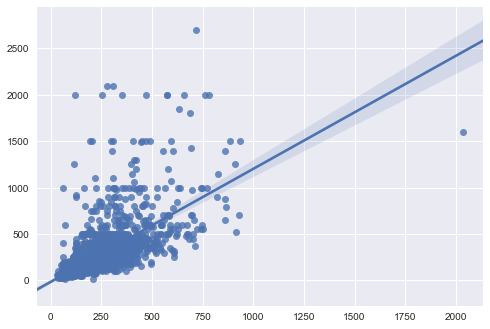

In [120]:
sns.regplot(np.exp(y_pred), np.exp(y_test))
# plt.plot(range(0,2000), range(0,2000))
# plt.xlim((0,1250))
# plt.ylim((0,2000))
plt.savefig('abnb_bline_lr.pdf');

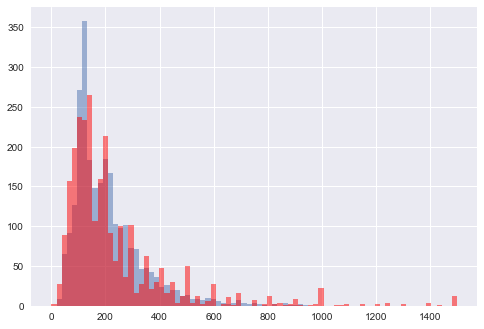

In [121]:
plt.hist(np.exp(y_pred), bins=np.linspace(0,1500, num=80), alpha=0.5)
plt.hist(np.exp(y_test), bins=np.linspace(0,1500, num=80), alpha=0.5, color='r');

In [91]:
lasso = LassoCV(cv=10, alphas=[0.0001, 0.001, 1, 100,1000, 10000], n_alphas=100)
lasso.fit(X_train, y_train)
y_pred = lasso.predict(X_test)
print rmse(y_pred, y_test)
lasso.score(X_test, y_test)

0.462695442609


0.62133326397275179

In [92]:
params = {'alpha':(0.0001, 0.001, 0.01, 1., 10., 100., 1000., 10000., 100000, 1000000)}

lasso = Lasso()
gs_lass = GridSearchCV(lasso, params, verbose=1)
gs_lass.fit(X_train, y_train)
gs_lass.best_params_

Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=1)]: Done  30 out of  30 | elapsed:    1.0s finished


{'alpha': 10000.0}

In [93]:
ridge = RidgeCV(cv=10, alphas=[200., 300., 400., 1000]) # alphas=np.linspace(0.001, 100000)
ridge.fit(X_train, y_train)
y_pred = ridge.predict(X_test)
print rmse(y_pred, y_test)
ridge.score(X_test, y_test)

0.469251609473


0.61052619433737809

In [94]:
print 'Percent within 5% of resid:   {}'.format(percent_within_x(y_pred, y_test, 5))
print 'Percent within 10% of resid:  {}'.format(percent_within_x(y_pred, y_test, 10))
print 'Percent within 20% of resid:  {}'.format(percent_within_x(y_pred, y_test, 20))
print 
print 'Median error (percent):  {}'.format(median_error(y_pred, y_test))

Percent within 5% of resid:   47.3663826491
Percent within 10% of resid:  77.1107668474
Percent within 20% of resid:  96.7467079783

Median error (percent):  5.3149595126


In [95]:
params = {'alpha':(1., 10., 50., 100., 200., 250., 300., 350., 500., 1000., 10000.)}

ridge = Ridge()
gs_ridg = GridSearchCV(ridge, params, verbose=1)
gs_ridg.fit(X_train, y_train)
gs_ridg.best_params_

Fitting 3 folds for each of 11 candidates, totalling 33 fits


[Parallel(n_jobs=1)]: Done  33 out of  33 | elapsed:    0.4s finished


{'alpha': 100.0}

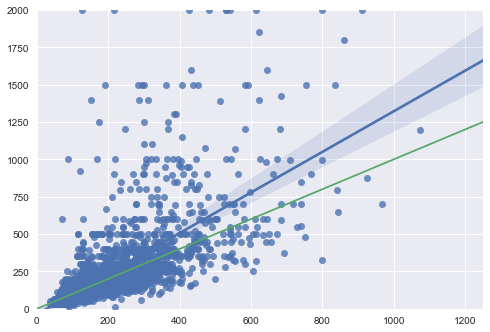

In [97]:
sns.regplot(np.exp(y_pred), np.exp(y_test))
plt.plot(range(0,2000), range(0,2000))
plt.xlim((0,1250))
plt.ylim((0,2000));

In [122]:
rfr = RandomForestRegressor(n_estimators=1000, n_jobs=6, 
                            min_samples_split=2, min_samples_leaf=1)
rfr.fit(X_train, y_train)
y_pred = rfr.predict(X_test)
print rmse(y_pred, y_test)
rfr.score(X_test, y_test)

0.403081143512


0.69862811303165406

In [123]:
print 'Percent within 5% of resid:   {}'.format(percent_within_x(np.exp(y_pred), np.exp(y_test), 5))
print 'Percent within 10% of resid:  {}'.format(percent_within_x(np.exp(y_pred), np.exp(y_test), 10))
print 'Percent within 20% of resid:  {}'.format(percent_within_x(np.exp(y_pred), np.exp(y_test), 20))
print 
print 'Median error (percent):  {}'.format(median_error(y_pred, y_test))

Percent within 5% of resid:   15.5693261038
Percent within 10% of resid:  28.8923315259
Percent within 20% of resid:  50.1936483346

Median error (percent):  3.93429950898


In [77]:
cross_val_score(rfr, X, y, cv=5)

array([ 0.52024769,  0.54740472,  0.61570067,  0.58027218,  0.59858608])

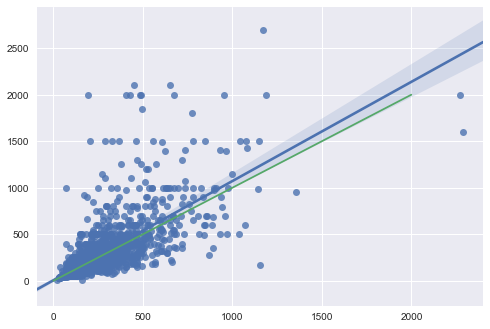

In [124]:
sns.regplot(np.exp(y_pred), np.exp(y_test))
plt.plot(range(0,2000), range(0,2000))
# plt.xlim((0,1250))
# plt.ylim((0,2000))
plt.savefig('abnb_bline_rfr.pdf');

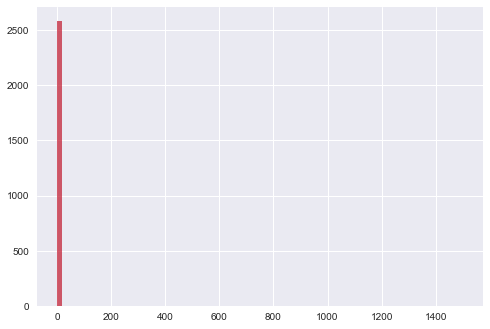

In [125]:
plt.hist(y_pred, bins=np.linspace(0,1500, num=80), alpha=0.5)
plt.hist(y_test, bins=np.linspace(0,1500, num=80), alpha=0.5, color='r');

In [81]:
etr = ExtraTreesRegressor(n_jobs=6, n_estimators=1000, bootstrap=True)
etr.fit(X_train, y_train)
y_pred = etr.predict(X_test)
print rmse(y_pred, y_test), '  ', np.sqrt(rmse(y_pred, y_test))
print mae(y_pred, y_test)
etr.score(X_test, y_test)


94.5174430349    9.72200817912
51.9662996152


0.62393688637331812

In [82]:
print 'Percent within 5% of price:   {}'.format(percent_within_x(y_pred, y_test, 5))
print 'Percent within 10% of price:  {}'.format(percent_within_x(y_pred, y_test, 10))
print 'Percent within 20% of price:  {}'.format(percent_within_x(y_pred, y_test, 20))
print 
print 'Median error (percent):  {}'.format(median_error(y_pred, y_test))

Percent within 5% of price:   14.3485431556
Percent within 10% of price:  28.1473336998
Percent within 20% of price:  49.4777350192

Median error (percent):  20.198


In [83]:
xgb = XGBRegressor(n_estimators=1000)
xgb.fit(X_train, y_train)
y_pred = xgb.predict(X_test)
print rmse(y_pred, y_test)
xgb.score(X_test, y_test)

98.0774207451


0.59507472910813175

In [84]:
print 'Percent within 5% of price:   {}'.format(percent_within_x(y_pred, y_test, 5))
print 'Percent within 10% of price:  {}'.format(percent_within_x(y_pred, y_test, 10))
print 'Percent within 20% of price:  {}'.format(percent_within_x(y_pred, y_test, 20))
print 
print 'Median error (percent):  {}'.format(median_error(y_pred, y_test))

Percent within 5% of price:   12.7542605827
Percent within 10% of price:  25.1786695987
Percent within 20% of price:  46.7289719626

Median error (percent):  21.7429428101


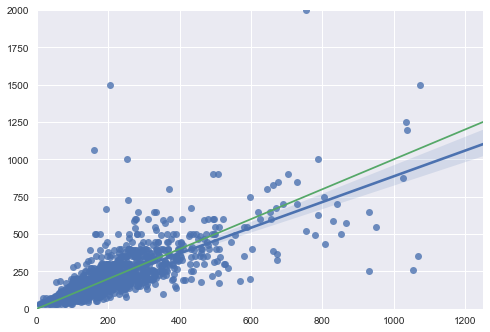

In [85]:
sns.regplot(y_pred, y_test)
plt.plot(range(0,2000), range(0,2000))
plt.xlim((0,1250))
plt.ylim((0,2000))
plt.savefig('abnb_bline_xgb.pdf');

In [99]:
# # ss = StandardScaler()
# # col_sc = ss.fit_transform()

# mymap = plt.get_cmap('brg')
# # get the colors from the color map
# colors = [X_test]
# my_colors = mymap(colors)
# # here you give floats as color to scatter and a color map
# # scatter "translates" this
# plt.scatter(y_pred, y_test, c=colors, cmap=mymap)
# #sns.regplot(y_pred, y_test)
# plt.plot(range(0,2000), range(0,2000))
# plt.show()

It appears that there are a few fake listings that are likely throwing off the regression results and making the rmse seem artificially high.

## 311 Data treatment

There's quite a bit of 311 data going back to 2008 or so. Will need to filter so that I only have the last couple of years, and also figure out a method for treating the categorical data. NB: the filename prefix is 'rec' for records.

***The majority of this analysis and editing of the 311 data is done in the other preliminary model notebook***

In [132]:
import datetime

In [133]:
rec_311.shape

(1821839, 16)

In [134]:
# rec_311['Opened'] = pd.to_datetime(rec_311.Opened, infer_datetime_format=True)
# rec_311['Closed'] = pd.to_datetime(rec_311.Opened, infer_datetime_format=True)
# rec_311['Updated'] = pd.to_datetime(rec_311.Opened, infer_datetime_format=True)
# rec_311

In [135]:
# pd.to_pickle(rec_311, '../project_data/rec_311_dt')

In [100]:
rec_311_dt = pd.read_pickle('../ga_project_data/rec_311_dt')

In [101]:
rec_311_dt.head(3)

CaseID              Opened              Closed             Updated  Status  \
0  322571 2008-11-30 23:53:00 2008-11-30 23:53:00 2008-11-30 23:53:00  Closed   
1  322568 2008-11-30 23:13:00 2008-11-30 23:13:00 2008-11-30 23:13:00  Closed   
2  322567 2008-11-30 23:07:00 2008-11-30 23:07:00 2008-11-30 23:07:00  Closed   

  Status Notes        Responsible Agency          Category  \
0          NaN  PUC - Electric/Power - G  General Requests   
1          NaN             DPW Ops Queue  Illegal Postings   
2          NaN             DPW Ops Queue  Illegal Postings   

                                   Request Type  \
0          puc - electric - request_for_service   
1  Illegal Postings - Posting_Too_Large_in_Size   
2         Illegal Postings - Affixed_Improperly   

                         Request Details  \
0   puc - electric - request_for_service   
1  Posting_Too_Large_in_Size on Sidewalk   
2         Affixed_Improperly on Sidewalk   

                                      Address  Supervisor District  \
0         Intersection of 21ST ST and CAPP ST                    9   
1    Intersection of BUSH ST and VAN NESS AVE                    3   
2  Intersection of EUCLID AVE and MASONIC AVE                    2   

       Neighborhood                                  Point    Source Media URL  
0           Mission  (37.7571008516766, -122.417811874214)  Voice In       NaN  
1          Nob Hill  (37.7884895281133, -122.421948485141)  Voice In       NaN  
2  Western Addition  (37.7850837365507, -122.447620029034)  Voice In       NaN

Sort the 311 datasets so that only data from 2015 and onwards are included - this still leaves plenty of data, but makes it more applicable (and also easier to handle).

In [102]:
print max(rec_311_dt.Opened)
print min(rec_311_dt.Opened)

2016-08-11 00:57:07
2008-03-20 11:48:32


In [142]:
rec_15up = rec_311_dt[rec_311_dt.Opened >= datetime.datetime(2015, 1, 1)]
rec_15up = rec_15up[rec_15up.Point.notnull()]
print rec_15up.shape
rec_15up

(577777, 16)


CaseID              Opened              Closed             Updated  \
3164     5012422 2015-08-19 08:00:55 2015-08-19 08:00:55 2015-08-19 08:00:55   
29136    5450427 2016-01-10 10:38:11 2016-01-10 10:38:11 2016-01-10 10:38:11   
48969    5050169 2015-08-31 09:02:50 2015-08-31 09:02:50 2015-08-31 09:02:50   
49384    5085637 2015-09-10 15:57:17 2015-09-10 15:57:17 2015-09-10 15:57:17   
49406    5451524 2016-01-10 18:39:10 2016-01-10 18:39:10 2016-01-10 18:39:10   
50545    5128084 2015-09-24 11:51:51 2015-09-24 11:51:51 2015-09-24 11:51:51   
51249    5148575 2015-09-30 23:07:12 2015-09-30 23:07:12 2015-09-30 23:07:12   
58723    4682131 2015-04-20 23:57:29 2015-04-20 23:57:29 2015-04-20 23:57:29   
58817    4682130 2015-04-20 23:55:44 2015-04-20 23:55:44 2015-04-20 23:55:44   
61335    4906656 2015-07-14 08:16:16 2015-07-14 08:16:16 2015-07-14 08:16:16   
61426    4906657 2015-07-14 08:16:24 2015-07-14 08:16:24 2015-07-14 08:16:24   
61542    4906661 2015-07-14 08:17:01 2015-07-14 08:17:01 2015-07-14 08:17:01   
62168    5411325 2015-12-28 17:31:08 2015-12-28 17:31:08 2015-12-28 17:31:08   
65772    4906662 2015-07-14 08:17:47 2015-07-14 08:17:47 2015-07-14 08:17:47   
65856    4906664 2015-07-14 08:17:48 2015-07-14 08:17:48 2015-07-14 08:17:48   
66265    5085299 2015-09-10 14:35:51 2015-09-10 14:35:51 2015-09-10 14:35:51   
66440    5444713 2016-01-08 09:14:41 2016-01-08 09:14:41 2016-01-08 09:14:41   
66658    5449573 2016-01-09 18:42:22 2016-01-09 18:42:22 2016-01-09 18:42:22   
68204    5450261 2016-01-10 09:23:45 2016-01-10 09:23:45 2016-01-10 09:23:45   
70162    5110636 2015-09-19 07:42:52 2015-09-19 07:42:52 2015-09-19 07:42:52   
70332    4906669 2015-07-14 08:20:18 2015-07-14 08:20:18 2015-07-14 08:20:18   
72201    4906672 2015-07-14 08:20:46 2015-07-14 08:20:46 2015-07-14 08:20:46   
72873    4906676 2015-07-14 08:21:52 2015-07-14 08:21:52 2015-07-14 08:21:52   
74723    5085315 2015-09-10 14:38:19 2015-09-10 14:38:19 2015-09-10 14:38:19   
75171    4972358 2015-08-06 08:03:49 2015-08-06 08:03:49 2015-08-06 08:03:49   
80837    5085318 2015-09-10 14:38:59 2015-09-10 14:38:59 2015-09-10 14:38:59   
84615    4922995 2015-07-20 08:26:30 2015-07-20 08:26:30 2015-07-20 08:26:30   
84630    5525078 2016-02-01 14:43:08 2016-02-01 14:43:08 2016-02-01 14:43:08   
85404    4973344 2015-08-06 13:28:52 2015-08-06 13:28:52 2015-08-06 13:28:52   
85738    4978185 2015-08-08 07:58:54 2015-08-08 07:58:54 2015-08-08 07:58:54   
...          ...                 ...                 ...                 ...   
1821089  5661443 2016-03-13 20:49:16 2016-03-13 20:49:16 2016-03-13 20:49:16   
1821090  5661450 2016-03-13 20:51:39 2016-03-13 20:51:39 2016-03-13 20:51:39   
1821092  5661481 2016-03-13 21:15:34 2016-03-13 21:15:34 2016-03-13 21:15:34   
1821093  5661488 2016-03-13 21:24:05 2016-03-13 21:24:05 2016-03-13 21:24:05   
1821094  5661445 2016-03-13 20:50:27 2016-03-13 20:50:27 2016-03-13 20:50:27   
1821095  5661442 2016-03-13 20:48:21 2016-03-13 20:48:21 2016-03-13 20:48:21   
1821096  5661495 2016-03-13 21:34:16 2016-03-13 21:34:16 2016-03-13 21:34:16   
1821097  5661507 2016-03-13 21:41:19 2016-03-13 21:41:19 2016-03-13 21:41:19   
1821098  5661505 2016-03-13 21:40:50 2016-03-13 21:40:50 2016-03-13 21:40:50   
1821099  5661518 2016-03-13 21:48:31 2016-03-13 21:48:31 2016-03-13 21:48:31   
1821100  5661523 2016-03-13 21:50:03 2016-03-13 21:50:03 2016-03-13 21:50:03   
1821101  5661539 2016-03-13 21:58:40 2016-03-13 21:58:40 2016-03-13 21:58:40   
1821102  5661544 2016-03-13 22:00:38 2016-03-13 22:00:38 2016-03-13 22:00:38   
1821103  5661548 2016-03-13 22:02:03 2016-03-13 22:02:03 2016-03-13 22:02:03   
1821104  5661550 2016-03-13 22:02:42 2016-03-13 22:02:42 2016-03-13 22:02:42   
1821105  5661552 2016-03-13 22:03:26 2016-03-13 22:03:26 2016-03-13 22:03:26   
1821106  5661553 2016-03-13 22:03:49 2016-03-13 22:03:49 2016-03-13 22:03:49   
1821107  5661543 2016-03-13 22:00:16 2016-03-13 22:00:16 2016-03-13 22:00:16   
1821108  5

Add or modify some of the features, inlcuding:

- Delete all of the requests (rows) with no 'Point', i.e. Lat/Long (DONE ABOVE)
- Expand the 'Point' feature, Lat/Long, into two more columns, 'latitude' and 'longitude'
- Create groups of categories for 'Category' feature, then dummy encode the grouped categories for each request
- Could clean the dataframe of all the requests where there was no reponse. These cases are typically closed immediately by the city or by the person who submitted the request
- (Might be tricky given different categories) create a time delta for the time it takes for requests to be closed after opening

In [143]:
rec_15up['latitude'] = rec_15up.Point.apply(lambda x: map(float, x.strip('()').split(', '))[0])
rec_15up['longitude'] = rec_15up.Point.apply(lambda x: map(float, x.strip('()').split(', '))[1])
#rec_15up['latitude'] = rec_15up.Point.apply(lambda x: x)
#rec_15up['longitude'] = rec_15up.Point.apply(lambda x: x[1])
rec_15up

CaseID              Opened              Closed             Updated  \
3164     5012422 2015-08-19 08:00:55 2015-08-19 08:00:55 2015-08-19 08:00:55   
29136    5450427 2016-01-10 10:38:11 2016-01-10 10:38:11 2016-01-10 10:38:11   
48969    5050169 2015-08-31 09:02:50 2015-08-31 09:02:50 2015-08-31 09:02:50   
49384    5085637 2015-09-10 15:57:17 2015-09-10 15:57:17 2015-09-10 15:57:17   
49406    5451524 2016-01-10 18:39:10 2016-01-10 18:39:10 2016-01-10 18:39:10   
50545    5128084 2015-09-24 11:51:51 2015-09-24 11:51:51 2015-09-24 11:51:51   
51249    5148575 2015-09-30 23:07:12 2015-09-30 23:07:12 2015-09-30 23:07:12   
58723    4682131 2015-04-20 23:57:29 2015-04-20 23:57:29 2015-04-20 23:57:29   
58817    4682130 2015-04-20 23:55:44 2015-04-20 23:55:44 2015-04-20 23:55:44   
61335    4906656 2015-07-14 08:16:16 2015-07-14 08:16:16 2015-07-14 08:16:16   
61426    4906657 2015-07-14 08:16:24 2015-07-14 08:16:24 2015-07-14 08:16:24   
61542    4906661 2015-07-14 08:17:01 2015-07-14 08:17:01 2015-07-14 08:17:01   
62168    5411325 2015-12-28 17:31:08 2015-12-28 17:31:08 2015-12-28 17:31:08   
65772    4906662 2015-07-14 08:17:47 2015-07-14 08:17:47 2015-07-14 08:17:47   
65856    4906664 2015-07-14 08:17:48 2015-07-14 08:17:48 2015-07-14 08:17:48   
66265    5085299 2015-09-10 14:35:51 2015-09-10 14:35:51 2015-09-10 14:35:51   
66440    5444713 2016-01-08 09:14:41 2016-01-08 09:14:41 2016-01-08 09:14:41   
66658    5449573 2016-01-09 18:42:22 2016-01-09 18:42:22 2016-01-09 18:42:22   
68204    5450261 2016-01-10 09:23:45 2016-01-10 09:23:45 2016-01-10 09:23:45   
70162    5110636 2015-09-19 07:42:52 2015-09-19 07:42:52 2015-09-19 07:42:52   
70332    4906669 2015-07-14 08:20:18 2015-07-14 08:20:18 2015-07-14 08:20:18   
72201    4906672 2015-07-14 08:20:46 2015-07-14 08:20:46 2015-07-14 08:20:46   
72873    4906676 2015-07-14 08:21:52 2015-07-14 08:21:52 2015-07-14 08:21:52   
74723    5085315 2015-09-10 14:38:19 2015-09-10 14:38:19 2015-09-10 14:38:19   
75171    4972358 2015-08-06 08:03:49 2015-08-06 08:03:49 2015-08-06 08:03:49   
80837    5085318 2015-09-10 14:38:59 2015-09-10 14:38:59 2015-09-10 14:38:59   
84615    4922995 2015-07-20 08:26:30 2015-07-20 08:26:30 2015-07-20 08:26:30   
84630    5525078 2016-02-01 14:43:08 2016-02-01 14:43:08 2016-02-01 14:43:08   
85404    4973344 2015-08-06 13:28:52 2015-08-06 13:28:52 2015-08-06 13:28:52   
85738    4978185 2015-08-08 07:58:54 2015-08-08 07:58:54 2015-08-08 07:58:54   
...          ...                 ...                 ...                 ...   
1821089  5661443 2016-03-13 20:49:16 2016-03-13 20:49:16 2016-03-13 20:49:16   
1821090  5661450 2016-03-13 20:51:39 2016-03-13 20:51:39 2016-03-13 20:51:39   
1821092  5661481 2016-03-13 21:15:34 2016-03-13 21:15:34 2016-03-13 21:15:34   
1821093  5661488 2016-03-13 21:24:05 2016-03-13 21:24:05 2016-03-13 21:24:05   
1821094  5661445 2016-03-13 20:50:27 2016-03-13 20:50:27 2016-03-13 20:50:27   
1821095  5661442 2016-03-13 20:48:21 2016-03-13 20:48:21 2016-03-13 20:48:21   
1821096  5661495 2016-03-13 21:34:16 2016-03-13 21:34:16 2016-03-13 21:34:16   
1821097  5661507 2016-03-13 21:41:19 2016-03-13 21:41:19 2016-03-13 21:41:19   
1821098  5661505 2016-03-13 21:40:50 2016-03-13 21:40:50 2016-03-13 21:40:50   
1821099  5661518 2016-03-13 21:48:31 2016-03-13 21:48:31 2016-03-13 21:48:31   
1821100  5661523 2016-03-13 21:50:03 2016-03-13 21:50:03 2016-03-13 21:50:03   
1821101  5661539 2016-03-13 21:58:40 2016-03-13 21:58:40 2016-03-13 21:58:40   
1821102  5661544 2016-03-13 22:00:38 2016-03-13 22:00:38 2016-03-13 22:00:38   
1821103  5661548 2016-03-13 22:02:03 2016-03-13 22:02:03 2016-03-13 22:02:03   
1821104  5661550 2016-03-13 22:02:42 2016-03-13 22:02:42 2016-03-13 22:02:42   
1821105  5661552 2016-03-13 22:03:26 2016-03-13 22:03:26 2016-03-13 22:03:26   
1821106  5661553 2016-03-13 22:03:49 2016-03-13 22:03:49 2016-03-13 22:03:49   
1821107  5661543 2016-03-13 22:00:16 2016-03-13 22:00:16 2016-03-13 22:00:16   
1821108  5

In [144]:
cats_311 = ['Temporary Sign Request', 'Color Curb', 'Graffiti Public Property',
            'Illegal Postings', 'Rec and Park Requests', '311 External Request',
            'General Requests', 'Street and Sidewalk Cleaning', 'Streetlights',
            'SFHA Requests', 'Street Defects', 'Damaged Property',
            'Sewer Issues', 'Litter Receptacles', 'Sign Repair',
            'MUNI Feedback', 'Graffiti Private Property',
            'Catch Basin Maintenance', 'Abandoned Vehicle', 'Tree Maintenance',
            'Sidewalk or Curb', 'Blocked Street or SideWalk',
            'Residential Building Request', 'Noise Report',
            'Interdepartmental Request', 'DPW Volunteer Programs',
            'Unpermitted Cab Complaint', 'Construction Zone Permits']

big_cats_311 = {'repair': ['Streetlights', 'Sewer Issues', 'Sign Repair', 'Sidewalk or Curb'], 
            'graffiti': ['Graffiti Public Property', 'Graffiti Private Property'], 
            'cosmetic': ['Color Curb', 'Illegal Postings', 'Rec and Park Requests', 
                         'Litter Receptacles', 'Tree Maintenance', ], 
            'construction': ['Temporary Sign Request', 'Noise Report', 
                             'Construction Zone Permits'], 
            'street': ['Street and Sidewalk Cleaning', 'Street Defects', 
                       'Catch Basin Maintenance'], 
            'other': ['311 External Request', 'General Requests', 'SFHA Requests', 
                      'Blocked Street or SideWalk', 'Residential Building Request', 
                      'Interdepartmental Request', 'DPW Volunteer Programs', 
                      'Unpermitted Cab Complaint'], 
            'damage': ['Damaged Property'], 
            'muni': ['MUNI Feedback'], 
            'Abandoned Vehicle': ['Abandoned Vehicle']}


In [145]:
rec_15up.Category.value_counts()

Street and Sidewalk Cleaning    225638
Graffiti Public Property         63264
Abandoned Vehicle                39217
Graffiti Private Property        38877
General Requests                 34436
Damaged Property                 16918
Sewer Issues                     16735
Illegal Postings                 15259
MUNI Feedback                    14983
Temporary Sign Request           13167
Streetlights                     12470
Tree Maintenance                 12413
Street Defects                   11987
Sign Repair                      11108
Litter Receptacles               10396
Rec and Park Requests             9611
SFHA Requests                     7523
Sidewalk or Curb                  7400
Blocked Street or SideWalk        6583
Noise Report                      2675
Residential Building Request      2280
311 External Request              1834
Color Curb                        1772
Interdepartmental Request          598
Catch Basin Maintenance            579
DPW Volunteer Programs   

Created imprecise categories for the 311 categories of requests. I think this might be obscuring some of the predictive potential of these categories. Creating dummies for them all would create a large amount of sparse columns, but when we bin the data by Lat/Long we will sum the counts for each category in the given bin.

In [146]:
cat_dummies = pd.get_dummies(rec_15up, columns=['Category'])
cat_dummies.T

3164     \
CaseID                                                                           5012422   
Opened                                                               2015-08-19 08:00:55   
Closed                                                               2015-08-19 08:00:55   
Updated                                                              2015-08-19 08:00:55   
Status                                                                            Closed   
Status Notes                                                             Case Resolved -   
Responsible Agency                         Port Authority - Temporary Sign Request Queue   
Request Type                                 Temporary Sign Request for Corporate_Events   
Request Details                        40 ft zone requested from 09/03/2015 to 09/14/...   
Address                                            1 FERRY PLZ, SAN FRANCISCO, CA, 94111   
Supervisor District                                                                    3   
Neighborhood                                                          Financial District   
Point                                                (37.79519943584, -122.393089418147)   
Source                                                                          Voice In   
Media URL                                                                            NaN   
latitude                                                                         37.7952   
longitude                                                                       -122.393   
Category_311 External Request                                                          0   
Category_Abandoned Vehicle                                                             0   
Category_Blocked Street or SideWalk                                                    0   
Category_Catch Basin Maintenance                                                       0   
Category_Color Curb                                                                    0   
Category_Construction Zone Permits                                                     0   
Category_DPW Volunteer Programs                                                        0   
Category_Damaged Property                                                              0   
Category_General Requests                                                              0   
Category_Graffiti Private Property                                                     0   
Category_Graffiti Public Property                                                      0   
Category_Illegal Postings                                                              0   
Category_Interdepartmental Request                                                     0   
Category_Litter Receptacles                                                            0   
Category_MUNI Feedback                                                                 0   
Category_Noise Report                                                                  0   
Category_Rec and Park Requests                                                         0   
Category_Residential Building Request                                                  0   
Category_SFHA Requests                                                                 0   
Category_Sewer Issues                                                                  0   
Category_Sidewalk or Curb                                                              0   
Category_Sign Repair                                                                   0   
Category_Street Defects                                                                0   
Category_Street and Sidewalk Cleaning                                                  0   
Category_Streetlights                                                                  0   
Category_Temporary Sign Request                                                        1   
Category_Tree Maintenance        

In [147]:
cat_dummies.shape

(577777, 45)

A plot of just a sample of the 311 requests.

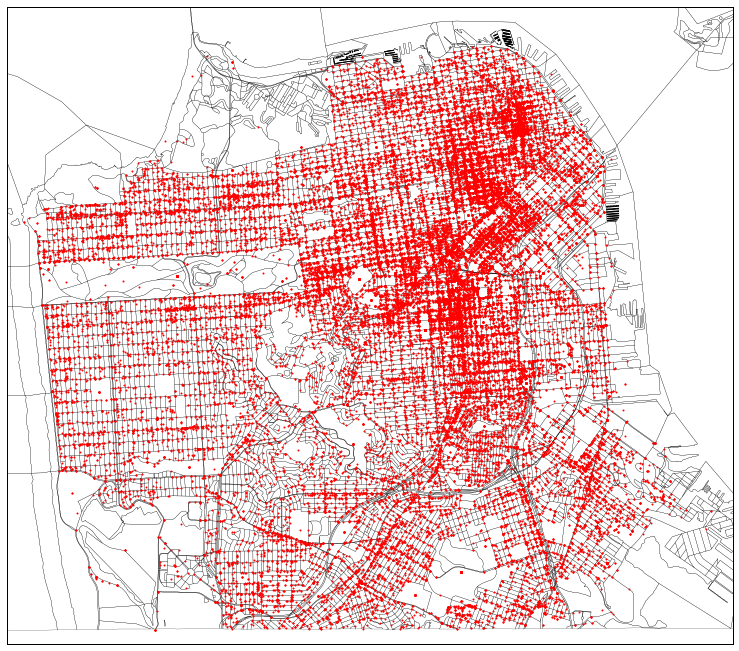

In [149]:
y = cat_dummies.latitude.values[:50000]
x = cat_dummies.longitude.values[:50000]

plt.figure(figsize=(13,13))
m = Basemap(llcrnrlon=-122.518,llcrnrlat=37.705683,urcrnrlon=-122.36,
            urcrnrlat=37.81534, resolution='h',projection='merc')

m.readshapefile('./map_data/census_blocks/geo_export_7c410ec8-5cfa-4422-9893-1d3d5cf3be1f','sf_blocks', linewidth=.2)

m.drawmapboundary(fill_color='white')

m.plot(x, y, 'ro', markersize=2, latlon=True)
#plt.title('contour lines over filled continent background')
plt.show()

Could also try using sklearn Kernal Density estimator - http://scikit-learn.org/stable/auto_examples/neighbors/plot_species_kde.html

/Users/taylorkilian/anaconda3/envs/dsi/lib/python2.7/site-packages/mpl_toolkits/basemap/__init__.py:3630: MatplotlibDeprecationWarning: The ishold function was deprecated in version 2.0.
  b = ax.ishold()
/Users/taylorkilian/anaconda3/envs/dsi/lib/python2.7/site-packages/mpl_toolkits/basemap/__init__.py:3699: MatplotlibDeprecationWarning: axes.hold is deprecated.
    See the API Changes document (http://matplotlib.org/api/api_changes.html)
    for more details.
  ax.hold(b)


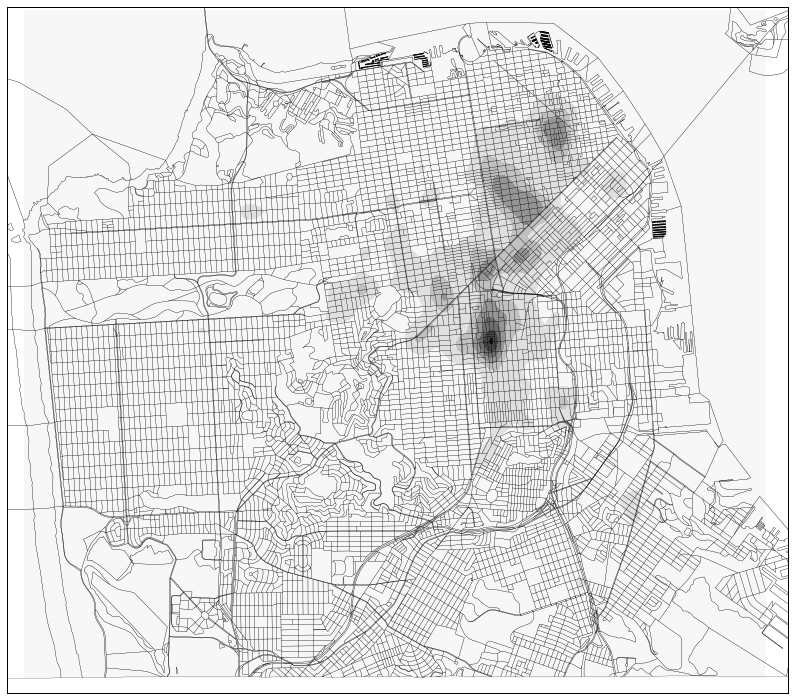

In [150]:
from scipy.stats.kde import gaussian_kde
# For heat map use gaussian kde and into mesh grid
k = gaussian_kde(np.vstack([x, y]), bw_method=0.05)
xi, yi = np.mgrid[x.min():x.max():x.size**0.5*1j,y.min():y.max():y.size**0.5*1j]
zi = k(np.vstack([xi.flatten(), yi.flatten()])).reshape(xi.shape)

plt.figure(figsize=(14,14))
# Lat/long for corners of map pulled from google maps
m = Basemap(llcrnrlon=-122.518,llcrnrlat=37.705683,urcrnrlon=-122.36,
            urcrnrlat=37.81534, resolution='h',projection='merc')
m.readshapefile('./map_data/census_blocks/geo_export_7c410ec8-5cfa-4422-9893-1d3d5cf3be1f','sf_blocks', linewidth=.2)
m.drawmapboundary(fill_color='white')
m.contourf(xi, yi, zi, latlon=True, )
# plot dots
#m.plot(x, y, 'bo', markersize=1, latlon=True)
plt.show()

## Crime data treatment

Similar to the 311 datasets, this crime data table is edited and modified in the other notebook - mostly in the same ways as below.

In [ ]:
# crimes_sf['Date'] = pd.to_datetime(crimes_sf.Date)

In [ ]:
# pd.to_pickle(crimes_sf, '../project_data/crimes_sf_dt')

In [152]:
crimes_sf_dt = pd.read_pickle('../ga_project_data/crimes_sf_dt')
crimes_sf_dt

IncidntNum        Category  \
0         110914565        WARRANTS   
1          11351210  MISSING PERSON   
2         120789988  MISSING PERSON   
3         140608681         ROBBERY   
4         140608681  OTHER OFFENSES   
5         140608681        WARRANTS   
6         150020821         ASSAULT   
7         150020978  OTHER OFFENSES   
8         150450739         SUICIDE   
9         150450739    NON-CRIMINAL   
10        150454907    NON-CRIMINAL   
11        150454929   LARCENY/THEFT   
12        150454963  OTHER OFFENSES   
13        150454963    NON-CRIMINAL   
14        150464570   LARCENY/THEFT   
15        150475533    NON-CRIMINAL   
16        140009459           ARSON   
17        150475759     WEAPON LAWS   
18        150475759     WEAPON LAWS   
19        150476274  OTHER OFFENSES   
20        150476274        WARRANTS   
21        150476274    NON-CRIMINAL   
22        150476826   VEHICLE THEFT   
23        150476854  OTHER OFFENSES   
24        150476989       VANDALISM   
25        150477454   LARCENY/THEFT   
26        150479331   LARCENY/THEFT   
27        150479347   LARCENY/THEFT   
28        150479353        BURGLARY   
29        150479381   LARCENY/THEFT   
...             ...             ...   
1945264   160135501         ASSAULT   
1945265   150968475         ASSAULT   
1945266   151083020         ASSAULT   
1945267   160135959   LARCENY/THEFT   
1945268   160135971        BURGLARY   
1945269   160135971        BURGLARY   
1945270   160135971       VANDALISM   
1945271   160135987  OTHER OFFENSES   
1945272   160135993   LARCENY/THEFT   
1945273   160135993  OTHER OFFENSES   
1945274   160135993         ASSAULT   
1945275   160136004         ASSAULT   
1945276   160176549         ASSAULT   
1945277   160300635  OTHER OFFENSES   
1945278   160315418   VEHICLE THEFT   
1945279   160317856        BURGLARY   
1945280   166032197    NON-CRIMINAL   
1945281   166062467    NON-CRIMINAL   
1945282   166067263    NON-CRIMINAL   
1945283   166085083    NON-CRIMINAL   
1945284   166087045    NON-CRIMINAL   
1945285   166088811   LARCENY/THEFT   
1945286    31281835    NON-CRIMINAL   
1945287    70477746         ASSAULT   
1945288   792640273    NON-CRIMINAL   
1945289    81076498  MISSING PERSON   
1945290    90578136   VEHICLE THEFT   
1945291   961392021  MISSING PERSON   
1945292   961392021    NON-CRIMINAL   
1945293   981021761        WARRANTS   

                                                  Descript  DayOfWeek  \
0                                           WARRANT ARREST     Friday   
1                                             FOUND PERSON    Tuesday   
2                                             FOUND PERSON     Monday   
3                                    ROBBERY, BODILY FORCE   Thursday   
4                              VIOLATION OF MUNICIPAL CODE   Thursday   
5                                           WARRANT ARREST   Thursday   
6        ELDER ADULT OR DEPENDENT ABUSE (NOT EMBEZZLEME...     Friday   
7                    DRIVERS LICENSE, SUSPENDED OR REVOKED  Wednesday   
8                           ATTEMPTED SUICIDE BY INGESTION   Saturday   
9                             AIDED CASE, MENTAL DISTURBED   Saturday   
10                                    LICENSE PLATE, FOUND     Monday   
11                                  GRAND THEFT PICKPOCKET     Sunday   
12                  FALSE EVIDENCE OF VEHICLE REGISTRATION     Monday   
13                                    LICENSE PLATE, FOUND     Monday   
14                                 GRAND THEFT OF PROPERTY     Friday   
15                                    AIDED CASE, DOG BITE     Sunday   
16                                                   ARSON   Saturday   
17                             CARRYING A CONCEALED WEAPON     Sunday   
18                                  POSS OF LOADED FIREARM     Sunday   
19                   STAY AWAY ORDER VIOLATION, DV RELATED     Sunday   
20                                          WARRANT ARRES

In [153]:
print max(crimes_sf_dt.Date)
print min(crimes_sf_dt.Date)

2016-07-28 00:00:00
2003-01-01 00:00:00


These records go all the way back to 2003. I'm going to cut restrict the analysis to dates after (and including) 2015.

In [154]:
crime_15up = crimes_sf_dt[crimes_sf_dt.Date >= datetime.datetime(2015, 1, 1)]
crime_15up.shape

(239095, 13)

In [155]:
crime_15up.Category.value_counts()

LARCENY/THEFT                  63751
OTHER OFFENSES                 31203
NON-CRIMINAL                   29374
ASSAULT                        20588
VANDALISM                      12187
VEHICLE THEFT                  11447
WARRANTS                       10271
BURGLARY                        9176
SUSPICIOUS OCC                  8546
MISSING PERSON                  7034
DRUG/NARCOTIC                   6757
ROBBERY                         5573
FRAUD                           4575
SECONDARY CODES                 3011
WEAPON LAWS                     2534
TRESPASS                        2377
STOLEN PROPERTY                 1470
SEX OFFENSES, FORCIBLE          1420
RECOVERED VEHICLE               1344
FORGERY/COUNTERFEITING          1097
DISORDERLY CONDUCT               875
DRUNKENNESS                      845
PROSTITUTION                     729
DRIVING UNDER THE INFLUENCE      620
ARSON                            485
KIDNAPPING                       479
LIQUOR LAWS                      261
E

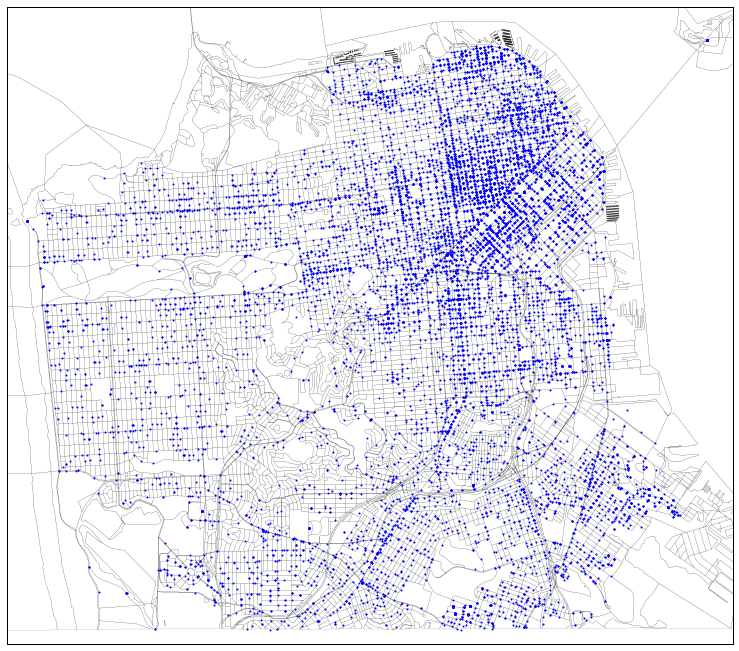

In [156]:
# y = crime_15up.Y.values[:50000]
# x = crime_15up.X.values[:50000]

y = crime_15up[crime_15up.Category == 'VANDALISM'].Y.values
x = crime_15up[crime_15up.Category == 'VANDALISM'].X.values

plt.figure(figsize=(13,13))
m = Basemap(llcrnrlon=-122.518,llcrnrlat=37.705683,urcrnrlon=-122.36,
            urcrnrlat=37.81534, resolution='h',projection='merc')

m.readshapefile('./map_data/census_blocks/geo_export_7c410ec8-5cfa-4422-9893-1d3d5cf3be1f','sf_blocks', linewidth=.1)

m.drawmapboundary(fill_color='white')

m.plot(x, y, 'bo', markersize=2, latlon=True)
#plt.title('contour lines over filled continent background')
plt.show()

Make some broader categories for the crime data. They might not end of being used, but it could be interesting to test the whether grouping into larger categories affects the model at all. The problem with grouping is that the categories exist for reasons - it is hard to condense them without masking possible signals.

In [158]:
cats_crime = ['WARRANTS', 'MISSING PERSON', 'ROBBERY', 'OTHER OFFENSES',
              'ASSAULT', 'SUICIDE', 'NON-CRIMINAL', 'LARCENY/THEFT',
              'WEAPON LAWS', 'VEHICLE THEFT', 'VANDALISM', 'BURGLARY',
              'DRUG/NARCOTIC', 'DRUNKENNESS', 'LIQUOR LAWS', 'SUSPICIOUS OCC',
              'RECOVERED VEHICLE', 'FRAUD', 'STOLEN PROPERTY',
              'DISORDERLY CONDUCT', 'SECONDARY CODES', 'TRESPASS', 'ARSON',
              'SEX OFFENSES, FORCIBLE', 'FORGERY/COUNTERFEITING', 'EMBEZZLEMENT',
              'RUNAWAY', 'PROSTITUTION', 'KIDNAPPING', 'GAMBLING',
              'DRIVING UNDER THE INFLUENCE', 'LOITERING', 'BRIBERY', 'EXTORTION',
              'FAMILY OFFENSES', 'BAD CHECKS', 'SEX OFFENSES, NON FORCIBLE',
              'PORNOGRAPHY/OBSCENE MAT', 'TREA']

big_cats_crime = {'theft_arson': ['ROBBERY', 'LARCENY/THEFT', 'VEHICLE THEFT', 
                                  'BURGLARY', 'STOLEN PROPERTY', 'ARSON'], 
                  'non_criminal': ['NON-CRIMINAL', 'MISSING PERSON', 'SUSPICIOUS OCC', 
                                   'RECOVERED VEHICLE', 'RUNAWAY'], 
                  'violent_crime': ['ASSAULT', 'WEAPON LAWS', 'SEX OFFENSES, FORCIBLE', 
                                    'KIDNAPPING', 'DRIVING UNDER THE INFLUENCE', 
                                    'FAMILY OFFENSES', 'SEX OFFENSES, NON FORCIBLE'],
                  'drugs_suicide': ['SUICIDE', 'DRUG/NARCOTIC', 'PROSTITUTION', 
                                    'PORNOGRAPHY/OBSCENE MAT'],
                  'vandalism_liquor': ['VANDALISM', 'DRUNKENNESS', 'LIQUOR LAWS', 
                                       'DISORDERLY CONDUCT', 'TRESPASS', 'LOITERING', 
                                       'TREA'], 
                  'other': ['WARRANTS', 'OTHER OFFENSES', 'SECONDARY CODES'], 
                  'money_related': ['FRAUD', 'FORGERY/COUNTERFEITING', 'EMBEZZLEMENT', 
                                    'GAMBLING', 'BRIBERY', 'EXTORTION', 'BAD CHECKS']}


## Park maps

The hypothesis is that rentals closer to parks are more desireable, therefore can be priced higher. This can possibly be accounted for by calculating distance to the nearest park.

Below I plot a shapefile of all San Francisco parks. In the map_data directory there is also a csv file with lat/long boundary points for every park.

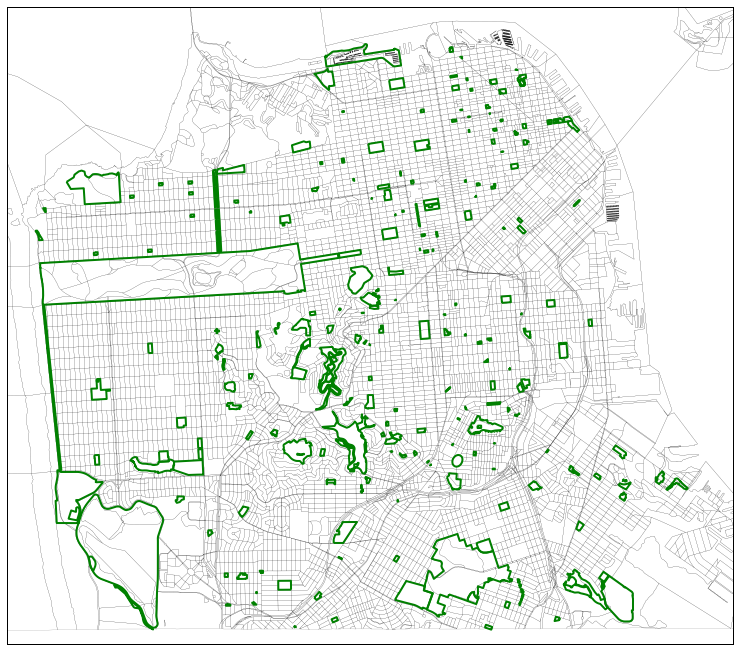

In [159]:
plt.figure(figsize=(13,13))
m = Basemap(llcrnrlon=-122.518,llcrnrlat=37.705683,urcrnrlon=-122.36,
            urcrnrlat=37.81534, resolution='h',projection='merc')

m.readshapefile('./map_data/census_blocks/geo_export_7c410ec8-5cfa-4422-9893-1d3d5cf3be1f',
                'sf_blocks', linewidth=.1)
m.readshapefile('./map_data/park_lands/geo_export_9cdf9323-886f-408a-bb55-833bfe6e102d',
                'sf_blocks', linewidth=2, color='g')

m.drawmapboundary(fill_color='white')

#m.plot(x, y, 'bo', markersize=2, latlon=True)
#plt.title('contour lines over filled continent background')
plt.show()

The csv below contains polygon boundary points for each of the parks (column name 'the_geom'). This is the column that will be used to see if a listing or property is close to a park - this might be considered a good attribute that would increase the value of a property. 

In [162]:
park_pnts = pd.read_csv('./map_data/RPD_Parks.csv')
print park_pnts.shape
park_pnts.head()

(222, 8)


map_park_n  \
0               Maritime Plaza   
1  Victoria Manalo Draves Park   
2    Crocker Amazon Playground   
3    Dearborn Community Garden   
4   Angelo J. Rossi Playground   

                                            the_geom    perimeter  gis_fd_pk  \
0  MULTIPOLYGON (((-122.39937368195233 37.7952515...  3208.814853        142   
1  MULTIPOLYGON (((-122.40553159596921 37.7762806...  1498.021103        169   
2  MULTIPOLYGON (((-122.43354460197526 37.7132539...  6738.886428        164   
3  MULTIPOLYGON (((-122.42291623023473 37.7622797...   338.000133     137654   
4  MULTIPOLYGON (((-122.45689530127527 37.7781510...  2609.521321        105   

            x          y          sqft      acres  
0 -122.399239  37.795605  8.767592e+04   2.012762  
1 -122.405955  37.777009  1.095939e+05   2.515930  
2 -122.429239  37.714046  2.459411e+06  56.460314  
3 -122.422744  37.762378  6.720006e+03   0.154270  
4 -122.457454  37.778742  2.818845e+05   6.471178

In [163]:
print park_scores.shape
park_scores.head()

(5495, 5)


ParkID   PSA                       Park      FQ  Score
0      86  PSA4           Carl Larsen Park  FY05Q3  0.795
1      13  PSA4  Junipero Serra Playground  FY05Q3  0.957
2       9  PSA4     Rolph Nicol Playground  FY05Q3  0.864
3     117  PSA2               Alamo Square  FY05Q4  0.857
4      60  PSA6   Jose Coronado Playground  FY05Q4  0.859

In [ ]:
# not as many parks as in park data table above (one with multipolygon)
park_scores.ParkID.unique().shape

The feature named 'the_geom' contains "MULTIPOLYGON" Lat/Long coordinates that trace the boundary of a given park. This could be used to check for the nearest distance to a park. 

There is also a file that has park scores which could be used to wait this somehow...

## Apply KDTrees - query radius

Find the amount of 311 requests within a given distance from each property. The query radius can only be given as a radius which is not ideal given that latitude and longitude degrees have different lengths at this latitude (longitude lines converge at the poles). The difference is not that significant, but the search areas will definitely be elliptical, long axis aligned N-S.

### Combine 311 data as counts of different Categories within the query radius

In [ ]:
bnb_list_full.reset_index(inplace=True, drop=True)
bnb_list_full.head().T

In [ ]:
big_cats_311

In [ ]:
# Not going to use the big categories for now...

rec_graff = rec_15up[(rec_15up.Category == 'Graffiti Public Property') | 
                     (rec_15up.Category == 'Graffiti Private Property')]
rec_graff_pts = rec_graff[['longitude', 'latitude']].as_matrix()

rec_noise_con = rec_15up[(rec_15up.Category == 'Temporary Sign Request') | 
                            (rec_15up.Category == 'Noise Report') | 
                            (rec_15up.Category == 'Construction Zone Permits')]
rec_noise_pts = rec_noise_con[['longitude', 'latitude']].as_matrix()

rec_cosmetic = rec_15up[(rec_15up.Category == 'Color Curb') | 
                        (rec_15up.Category == 'Illegal Postings') | 
                        (rec_15up.Category == 'Rec and Park Requests') | 
                        (rec_15up.Category == 'Litter Receptacles') | 
                        (rec_15up.Category == 'Tree Maintenance')]
rec_cosmetic_pts = rec_cosmetic[['longitude', 'latitude']].as_matrix()

rec_damage = rec_15up[rec_15up.Category == 'Damaged Property']
rec_damage_pts = rec_damage[['longitude', 'latitude']].as_matrix()

rec_repair = rec_15up[(rec_15up.Category == 'Streetlights') | 
                        (rec_15up.Category == 'Sewer Issues') | 
                        (rec_15up.Category == 'Sign Repair') | 
                        (rec_15up.Category == 'Sidewalk or Curb')]
rec_repair_pts = rec_repair[['longitude', 'latitude']].as_matrix()

rec_street = rec_15up[(rec_15up.Category == 'Street and Sidewalk Cleaning') | 
                            (rec_15up.Category == 'Street Defects') | 
                            (rec_15up.Category == 'Catch Basin Maintenance')]
rec_street_pts = rec_street[['longitude', 'latitude']].as_matrix()

In [ ]:
rec_15up.Category.value_counts()

In [ ]:
# test = bnb_list_full.loc[0, ['longitude', 'latitude']].values.reshape(1,-1)
test = bnb_list_full.loc[0:2, ['longitude', 'latitude']].as_matrix()
test

In [ ]:
from sklearn.neighbors import KDTree

def find_neigh_cnt(col_name, X_pts, centers_df, r=0.0045, leaf_size=2):
    tmp = centers_df.loc[:, ['longitude', 'latitude']].as_matrix()
    tree = KDTree(X_pts, leaf_size=2)     
    cnts_per_center = tree.query_radius(tmp, r=0.0045, count_only=True)
    centers_df[col_name] = cnts_per_center
    return centers_df

Use KDTree from sklearn to get counts of points within a certain distance of given point - this is applied to all the desired categories. Arrays (matrices) are created (above) containing the Lat/Long points for each category.

In [ ]:
bnb_list_app = pd.DataFrame(bnb_list_full)
bnb_list_app = find_neigh_cnt('graffiti_cnt', rec_graff_pts, bnb_list_app)
bnb_list_app = find_neigh_cnt('constr_and_noise_cnt', rec_noise_pts, bnb_list_app)
bnb_list_app = find_neigh_cnt('cosmetic_cnt', rec_cosmetic_pts, bnb_list_app)
bnb_list_app = find_neigh_cnt('damage_cnt', rec_damage_pts, bnb_list_app)
bnb_list_app = find_neigh_cnt('repair_cnt', rec_repair_pts, bnb_list_app)
bnb_list_app = find_neigh_cnt('street_cnt', rec_street_pts, bnb_list_app)
bnb_list_app

In [ ]:
#bnb_list_full = bnb_list_full.applymap(conv_to_float)
y = bnb_list_app.price.values
drop_cols = ['price_mod', 'price_y', 'price', 'latitude', 'longitude', 
             'amenities']
keep_cols = [x for x in bnb_list_app.columns.values if x not in drop_cols]
X = bnb_list_app[keep_cols]

ss = StandardScaler()
Xs = ss.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=2)

linreg = LinearRegression()
linreg.fit(X_train, y_train)
y_pred = linreg.predict(X_test)
print rmse(y_pred, y_test)
linreg.score(X_test, y_test)


In [ ]:
rfr = RandomForestRegressor(n_estimators=1000, n_jobs=4, 
                            min_samples_split=2, min_samples_leaf=1)
rfr.fit(X_train, y_train)
y_pred = rfr.predict(X_test)
print rmse(y_pred, y_test)
rfr.score(X_test, y_test)


In [ ]:
xgb = XGBRegressor(max_depth=10, n_estimators=1000)
xgb.fit(X_train, y_train)
y_pred = xgb.predict(X_test)
print rmse(y_pred, y_test)
xgb.score(X_test, y_test)


In [ ]:
cross_val_score(xgb, X, y, n_jobs=4, cv=4)

In [ ]:
sns.regplot(y_pred, y_test)
plt.plot(range(0,2000), range(0,2000))
# plt.xlim((0,6000))
# plt.ylim((0,2000));

***Quick model tests on new round of assesors data***

In [ ]:
res_rolls_cut

In [58]:
res_rolls_app = pd.DataFrame(res_rolls_cut)
# res_rolls_app = find_neigh_cnt('graffiti_cnt', rec_graff_pts, res_rolls_app)
# res_rolls_app = find_neigh_cnt('constr_and_noise_cnt', rec_noise_pts, res_rolls_app)
# res_rolls_app = find_neigh_cnt('cosmetic_cnt', rec_cosmetic_pts, res_rolls_app)
# res_rolls_app = find_neigh_cnt('damage_cnt', rec_damage_pts, res_rolls_app)
# res_rolls_app = find_neigh_cnt('repair_cnt', rec_repair_pts, res_rolls_app)
# res_rolls_app = find_neigh_cnt('street_cnt', rec_street_pts, res_rolls_app)
# res_rolls_app

In [72]:
test = res_rolls_app[(res_rolls_app.land_and_impro_val > 100000) & 
                     (res_rolls_app.land_and_impro_val < 3000000)]
test.shape

(183969, 13)

In [61]:
test

Number of Bathrooms  Number of Bedrooms  Number of Rooms  \
0                       3.0                   3                6   
1                       3.0                   3                5   
2                       2.0                   2               10   
7                       3.0                   3                5   
8                      10.0                  10               22   
18                      4.0                   4               12   
20                      1.0                   1                3   
23                      4.0                   4                9   
30                      4.0                   4                8   
36                      2.0                   2                4   
41                      3.0                   3                7   
47                      2.0                   2                4   
48                      4.0                   4               10   
49                      9.0                   9               21   
55                      1.0                   1                3   
57                      2.0                   2                4   
59                      1.0                   1                3   
61                      4.0                   4               10   
62                      3.0                   3                6   
63                      2.0                   2                5   
64                      1.0                   1                3   
65                      4.0                   4                7   
67                      3.0                   3                6   
70                      4.0                   4                7   
71                      2.0                   2                6   
72                      4.0                   4                4   
73                      4.0                   4                8   
74                      4.0                   4                7   
77                      2.0                   2                5   
86                      2.0                   2                5   
...                     ...                 ...              ...   
502398                  7.0                   7               14   
502400                  5.0                   5               15   
502404                  6.0                   6               18   
502406                  3.0                   3               12   
502408                  9.0                   9               19   
502412                  4.0                   4               17   
502415                  6.0                   6               14   
502416                  8.0                   8               17   
502417                  5.0                   5               13   
502418                  5.0                   5               14   
502419                  9.0                   9               15   
502420                 11.0                  11               31   
502426                  6.0                   6               10   
502427                  7.0                   7               13   
502429                  4.0                   4                6   
502433                  5.0                   5               14   
502434                  4.0                   4                6   
502435                  4.0                   4                9   
502439                 18.0                  18               54   
502441                  5.0                   5               12   
502443                  5.0                   5               11   
502444                  3.0                   3                6   
502445                  6.0                   6               10   
502454                  9.0                   9               18   
502455                  6.0                   6               11   
502460                  5.0                   5                9   
502464                  4.0                   4               10

In [73]:
#bnb_list_full = bnb_list_full.applymap(conv_to_float)
y = test.land_and_impro_val.values
drop_cols = ['latitude', 'longitude', 'land_and_impro_val', 'geometry', 'census_tract']
keep_cols = [x for x in test.columns.values if x not in drop_cols]
X = test[keep_cols]

ss = StandardScaler()
Xs = ss.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=2)

linreg = LinearRegression()
linreg.fit(X_train, y_train)
y_pred = linreg.predict(X_test)
print rmse(y_pred, y_test)
linreg.score(X_test, y_test)


456289.795558


0.10975092746898041

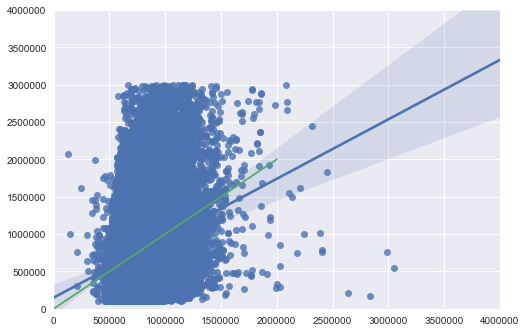

In [74]:
sns.regplot(y_pred, y_test)
plt.plot(range(0,2000000), range(0,2000000));
plt.xlim((0,4000000))
plt.ylim((0,4000000));

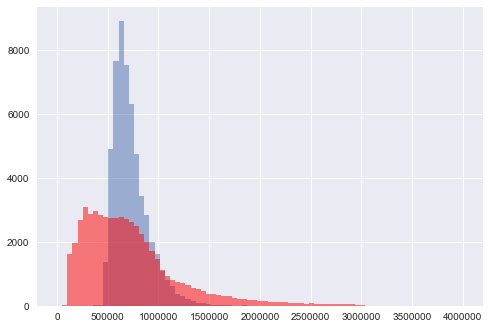

In [75]:
plt.hist(y_pred, bins=np.linspace(0,4000000, num=80), alpha=0.5)
plt.hist(y_test, bins=np.linspace(0,4000000, num=80), alpha=0.5, color='r');

In [76]:
rfr = RandomForestRegressor(n_estimators=1000, n_jobs=6, 
                            min_samples_split=2, min_samples_leaf=1)
rfr.fit(X_train, y_train)
y_pred = rfr.predict(X_test)
print rmse(y_pred, y_test)
rfr.score(X_test, y_test)


275706.384283


0.67496983914020581

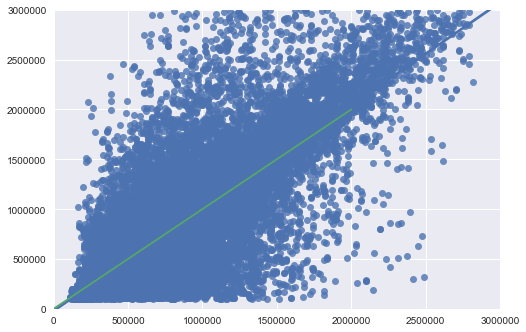

In [80]:
sns.regplot(y_pred, y_test)
plt.plot(range(0,2000000), range(0,2000000));
plt.xlim((0,3000000))
plt.ylim((0,3000000));

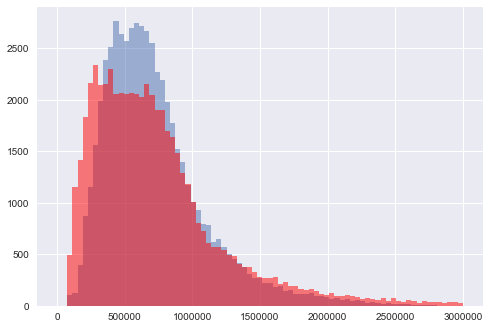

In [81]:
plt.hist(y_pred, bins=np.linspace(0,3000000, num=80), alpha=0.5)
plt.hist(y_test, bins=np.linspace(0,3000000, num=80), alpha=0.5, color='r');

In [82]:
print 'Percent within 5% of price:   {}'.format(percent_within_x(y_pred, y_test, 5))
print 'Percent within 10% of price:  {}'.format(percent_within_x(y_pred, y_test, 10))
print 'Percent within 20% of price:  {}'.format(percent_within_x(y_pred, y_test, 20))
print 
print 'Median error (percent):  {}'.format(median_error(y_pred, y_test))

Percent within 5% of price:   21.3621786161
Percent within 10% of price:  37.2977478212
Percent within 20% of price:  58.2450037144

Median error (percent):  15.4086058002


In [ ]:
xgb = XGBRegressor(max_depth=10, n_estimators=1000)
xgb.fit(X_train, y_train)
y_pred = xgb.predict(X_test)
print rmse(y_pred, y_test)
xgb.score(X_test, y_test)


In [ ]:
sns.regplot(y_pred, y_test)
plt.plot(range(0,800000), range(0,800000));
plt.xlim((0,800000))
plt.ylim((0,800000));

Next objective is to add the rest of the count data from crime and also from parks and data.